> # Истражувачка анализа на финансиски податоци од берзата на САД
> #### Јован Крајевски (199015)
> ##### јануари, 2021
---

# Вовед

Целта на овој проект е да се анализираат акциите на берзата на САД, да се испитаат разликите помеѓу акции од различни сфери и кои потекнуваат од компании од различна вредност и да се испита корелацијата помеѓу промената на вредноста на акциите на берзата и порастот на нееднаквоста во САД. 

Ќе започнеме анализирајќи ги три од најпознати индекси на берзата на САД: S&P 500, Dow Jones Industrial Average и Nasdaq Composite и спредувајќи ги со индексот The Wilshire 5000, кој е составен од сите (околу) 5000 акции на берзата на САД.
Понатаму, ќе ги разгледаме цените на неколку акции од овие индекси, обидувајќи се да најдеме некои статистички значајни разлики помеѓу нив. На крај, ќе се обидеме да ја испитаме корелацијата помеѓу промената на вредноста на овие индекси и порастот на нееднаквоста во САД. 

# Собирање на податоци од берзата на САД

## Како фунцкионираат берзите?

На берзата постојат два типа на ентитети: **продавачи** и **купувачи**.

Повеќе продавачи можат да се приклучат на берзата и да ги понудат своите акции. Понудата за продажба на акции се нарекува **продажна нарачка**. Истовремено, повеќе купувачи можат да се приклучат на берзата и да се понудат да купат акции. Понудата за купување на акции се нарекува **куповна нарачка**. Продажните и купувачките нарачки се градбените единици на берзата.

Постојат различни типови на продажни и куповни нарачки, но тука ќе ги разгледаме најчестите две. Пософистицираните типови на нарачки не се од посебен интерес за преоктов, бидејќи не е целта да се тестираат различни стратегии за учество на берзата. Напротив, ниту овие нарачки не се од посебен интерес за оваа анализа, но нивното објаснување е корисно за да се дефинираат одредени случајни променливи кои ќе ги користиме во натамошните испитувања.

### Лимитирачки нарачки

Основниот тип на нарачка, било да е продажна или куповна, е **лимитирачката** нарачка. Со овој тип на нарачка, ентитетот X вели: *јас сум подготвен да купам/продадам $v$ акции ако и само ако некој друг ентитет е подготвен да ми ги продаде/купи овие акции по цена $M$*. Да го означиме овој тип на нарачка со $L_{buy, v, M}$, ако е продажна, или $L_{sell, v, M}$ ако е куповна. 

Секогаш кога постои пар на нарачки $L_{buy, v_1, M_1}$ и $L_{sell, v_2, M_2}$ за кои важи $M_1 \geq M_2$, на берзата се случува трансакција. После трансакцијата, во која што настанува размена на $min(v_1, v_2)$ акции по цена $M_2$, продажната нарачка продолжува да нуди $v_1 - min(v_1, v_2)$ акции за продажба, а куповната продолжува да бара $v_2 - min(v_1, v_2)$ акции за купување. Јасно е дека едната од овие две нарачки ќе биде **целосно исполнета** и ќе престане да биде дел од берзата бидејќи барем еден од броевите $v_1 - min(v_1, v_2)$ и $v_2 - min(v_1, v_2)$ е $0$.

Важно е да се напомене дека претходниот параграф не нужно е точен во случајот $M_1 > M_2$, односно цената по која што ќе се изврши трансакцијата во овој случај не мора да е $M_2$. Но, можеме да претпоставиме дека така функционира берзата, без притоа оваа претпоставка да има какво било влијание на понатамошната анализа.

Од тука, трансакција помеѓу две лимитирачки нарачки можеме да дефинираме како функција на следниов начин: 

$$
transaction(L_{buy, v_1, M_1}, L_{sell, v_2, M_2}) = \begin{cases}
(L_{buy, v_1, M_1}, L_{sell, v_2, M_2}), &\mbox{ако } M_1 < M_2 \\
(L_{buy, v_1 - v_2, M_1}), &\mbox{ако } M_1 \geq M_2 \text{ и } v_1 > v_2 \\
(L_{sell, v_2 - v_1, M_2}), &\mbox{ако } M_1 \geq M_2 \text{ и } v_1 < v_2 \\
(), &\mbox{ако } M_1 \geq M_2 \text{ и } v_1 = v_2
\end{cases}
$$

На берзата, оваа функција се извршува константно, така што во секој момент од **множеството на лимитирачки нарачки** $limitOrders$ се избира парот $(L_{buy, v_1, M_1}, L_{sell, v_2, M_2})$ со најниска ненегативна вредност на разликата $M_2 - М_1$, двете нарачки се отстрануваат од множеството на лимитирачки нарачки и во него се додаваат лимитирачките нарачки од торката резултат на $transaction(L_{buy, v_1, M_1}, L_{sell, v_2, M_2})$.

Кога веќе нема да може да се избере пар за кој трансакцијата ќе резултира во торка со помалку од 2 елементи, берзата **мирува**. Во овој момент на мирување, доколку во множеството на лимитирачки нарачки има останато и продажни и куповни лимитирачки нарачки, тогаш $ask = \inf{\{M_i | L_{sell, v_i, M_i} \in limitOrders \}}$, $bid = \sup{\{M_i | L_{buy, v_i, M_i} \in limitOrders \}}$ и важи $ask > bid$. Тоа значи дека ако ги претставиме преостанатите лимитирачки нарачки на една бројна права што ја претставува цената, сите куповни нарачки ќе се најдат лево од $bid$, а сите продажни нарачки ќе се најдат десно од $ask$. 

### Пазарни нарачки

**Пазарните нарачки** немаат прецизирана цена. Со нив, ентитетот Х вели: *јас сум подготвен да купам/продадам $v$ акции по најниската/највисоката можна цена*. Впрочем, ако ентитетот X купува акции, тој ќе ги купи акциите по цена $ask$, а ако продава, тој ќе ги продаде акциите по цена $bid$. Ваквите нарачки ќе ги бележиме со $M_{buy, v}$, ако се куповни, и $M_{sell, v}$.

Важно е да се напомене дека пазарната нарачка не секогаш може да се комплетира со една лимитирачка нарачка. Често пати, пазарната нарачка не може да се комплетира ниту со лимитирачки нарачки кои имаат иста цена. Во ваков случај, куповната пазарна нарачка нема да биде комплетирана по просечна цена $ask$, туку по просечна цена повисока од $ask$. Аналогно на тоа, и продажната пазарна нарачка нема да биде комплетирана по просечна цена $bid$, туку по просечна цена пониска од $bid$. Оваа појава е целосно опфатена во дефинирањето на трансакциите кои следат подоле.

Трансакција помеѓу пазарна продажна и лимитирачка куповна нарачка се дефинира на следниов начин:

$$
transaction(L_{buy, v_1, M_1}, М_{sell, v_2}) = \begin{cases}
(L_{buy, v_1 - v_2, M_1}), &\mbox{ако } v_1 > v_2 \\
(М_{sell, v_2 - v_1}), &\mbox{ако } v_1 < v_2 \\
(), &\mbox{ако } v_1 = v_2
\end{cases}
$$

Трансакција помеѓу пазарна куповна и лимитирачка продажна нарачка се дефинира на следниов начин:

$$
transaction(L_{sell, v_1, M_1}, М_{buy, v_2}) = \begin{cases}
(L_{sell, v_1 - v_2, M_1}), &\mbox{ако } v_1 > v_2 \\
(М_{buy, v_2 - v_1}), &\mbox{ако } v_1 < v_2 \\
(), &\mbox{ако } v_1 = v_2
\end{cases}
$$

## OHLCV кантички

Историските податоци на берзата традиционално се претставуваат со OHLCV кантички дефинирани на одреден временски интервал $[openTime, closeTime + t]$, каде $t > 0$. $t$ најчесто претставува 1 минута, 5 минути, 15 минути, 1 ден, 1 месец.

Во секој ваков временски интервал се случуваат низа на трансакции. Да дефинираме случјна променливи $P_i$ - цената по која што се извршила $i$-тата трансакција во интервалот $[openTime, closeTime + t]$ и $V_i$ - бројот на акции кои се купиле/продале во $i$-тата трансакција во интервалот $[openTime, closeTime + t]$. Тогаш, за погоре дефинираните трансакции кои резултираат со **помалку од две нарачки** (бидејќи, настрана дефинициите во проектов, само тие трансакции навистина се трансакции), имаме:

|$i$-та трансакција|$P_i$|$V_i$|
|---|---|---|
|$$transaction(L_{buy, v_1, M_1}, L_{sell, v_2, M_2})$$|$$M_2$$|$$min\{v_1, v_2\}$$|
|$$transaction(L_{buy, v_1, M_1}, М_{sell, v_2})$$|$$M_1$$|$$min\{v_1, v_2\}$$|
|$$transaction(L_{sell, v_1, M_1}, М_{buy, v_2})$$|$$M_1$$|$$min\{v_1, v_2\}$$|

OHLCV кантичката за интервалот $[openTime, closeTime + t]$ се состои од 5 статистики врз случајните променливите $P_i$ и $V_i$. Имено, OHLCV е кратенка од Open, High, Low, Close, Volume, па како што и името наговестува, OHLCV кантичката е торка од 5 статистики: цената по која била извршена првата трансакција (Open), цената по која била извршена трансакцијата со највисока цена (High), цената по која била извршена трансакцијата со најниска цена (Low), цената по која била извшрена последната трансакција (Close) и вкупниот број на акции кои биле купени/продадени во овој интервал (Volume). Математички изразено,

$$
open(\{P_1, ..., P_N\}) = P_1 \\
high(\{P_1, ..., P_N\}) = max\{P_1, ..., P_{N}\} \\
low(\{P_1, ..., P_N\}) = min\{P_1, ..., P_{N}\} \\
close(\{P_1, ..., P_N\}) = P_N \\
volume(\{V_1, ..., V_N\}) = \sum_{i=1}^{N} V_i \\
OHLCV_{[openTime, closeTime + t]} = (open(\{P_1, ..., P_N\}), high(\{P_1, ..., P_N\}), low(\{P_1, ..., P_N\}), close(\{P_1, ..., P_N\}), volume(\{P_1, ..., P_N\}))
$$

## Индекси

При анализа на берзата, често е од интерес да се дадат одговори на прашања кои ја засегаат целокупната берза, или некој дел од берзата, а не една поединечна акција. Пример, за да дадеме одговор на прашањата „дали цените на берзата опаѓаат?“ или „дали има економска криза на берзата?“, мораме да погледнеме повеќе акции истовремено.

Погоре ја дефиниравме случајната променлива $P_i$ - цената по која се извршила i-тата транскација на берзата. Но, погоре зборевме само за трансакции за една акција. Да дефинираме нова случајна променлива, $P_{i, j}$ - цената по која се извршила i-тата транскација за ј-тата акција на берзата. Сега можеме да дефинираме посебни типови на статистики - индекс статистики. 

Индекс статистиките во суштина се тежински (пондерирани? - weighted) аритметички средини на статистиките дефинирани во делот за OHLCV кантичките. Најчесто, во еден индекс, на акциите им се препишуваат тежини $\alpha_j, 1 \le j \le M, M$ - број на акции. Овие тежини можат да бидат базирани на market cap-от на акцијата (број на акции во оптек * цена на една акција), на волуменот, на типот на акција (пример, некои индекси ставаат тежини 0 на сите акции кои не се од одреден тип на индустрија, за да можат да ја доловат состојбата со конкретната индустрија од интерес) итн. Анализата на начинот на кој што се одредуваат тежините во индексот не припаѓа на опсегот на оваа проектна задача.

Откако се одредени тежините $\alpha_j$, можеме да ги дефинираме следниве индекс статистики:

$$
indexOpen(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}) = \sum_{j=1}^{M}\alpha_{j}P_{1,j} \\
indexHigh(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}) = max\{\sum_{j=1}^{M}\alpha_{j}P_{1,j}, ..., \sum_{j=1}^{M}\alpha_{j}P_{N,j}\} \\
indexLow(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}) = min\{\sum_{j=1}^{M}\alpha_{j}P_{1,j}, ..., \sum_{j=1}^{M}\alpha_{j}P_{N,j}\} \\
indexClose(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}) = \sum_{j=1}^{M}\alpha_{j}P_{N,j} \\
volume(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}) = \sum_{i=1}^{n} V_i \\
indexOHLCV_{[openTime, closeTime + t]} = \\
(indexOpen(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}), \\
indexHigh(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}), \\
indexLow(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}), \\
indexClose(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}), \\
indexVolume(\{P_{1, 1}, ..., P_{1, M}, ..., P_{N, 1}, ..., P_{N, M}\}))
$$


## Опис на библиотеката `yfinance`

Податоците од берзата на САД ќе бидат собрани користејќи го Yahoo finance и библиотеката `yfinance`. `yfinance` е библиотека што овозможува лесно да се превземат историските податоци достапни на Yahoo finance, но, како и секоја библиотека во светот на финансиите, доаѓа со свои ограничувања.

Имено, за временски интервали помали од 24 часа (т.н. intraday податоци) не можеме да ги земеме сите достапни OHLCV кантички, туку само оние во претходните 60 дена. Колку што повеќе се намалува временскиот интервал, толку помалку достапни стануваат самите OHLCV кантички. За постари intraday податоци, најчесто е потребно да се плати.

Генерално ќе работиме со дневни историски податоци, а intraday податоците ќе ги користиме за да извлечеме некои помалку значајни заклучоци за распределбата на прирастот по часови.

## Симнување на податоците

Пред да започнеме со симнување на податоците, ќе дефинираме листи на индекси и акции кои ќе ги анализираме. Притоа, ова се акции кои во моментот на правење на овој проект биле дел од трите индекси. Индексите периодично се менуваат, па некои акции излегуваат, а некои се додаваат. Овие индекси исто така имаат и акции кои се преклопуваат, па затоа на крај, во `all_tickers` ги чуваме само уникатните акции (532 на број). Конвертирање на листа во сет ги отстранува дупликатите (сетовите не чуваат копии), па затоа композицијата `list(set(X))` е познат начин на отстранување на дуплиакти од `X`.

In [1]:
import yfinance

indexes = ["^W5000", "^GSPC", "^IXIC", "^DJI"]

gspc_tickers = [
    "AAPL", "MSFT", "AMZN", "FB", "TSLA", "GOOGL", "GOOG", "JNJ", "JPM", "V",
    "PG", "UNH", "DIS", "NVDA", "MA", "HD", "PYPL", "VZ", "ADBE", "CMCSA",
    "NFLX", "BAC", "KO", "MRK", "PEP", "T", "PFE", "INTC", "CRM", "WMT", "ABT",
    "ABBV", "CSCO", "TMO", "NKE", "AVGO", "XOM", "QCOM", "COST", "ACN", "CVX",
    "MCD", "MDT", "NEE", "TXN", "HON", "DHR", "UNP", "BMY", "LIN", "LLY",
    "AMGN", "PM", "C", "SBUX", "WFC", "ORCL", "UPS", "LOW", "BA", "IBM", "AMD",
    "RTX", "NOW", "BLK", "MMM", "INTU", "AMT", "CAT", "MS", "CHTR", "ISRG",
    "GE", "BKNG", "GS", "CVS", "TGT", "FIS", "LMT", "DE", "MU", "MDLZ", "TJX",
    "SYK", "ANTM", "SCHW", "SPGI", "AXP", "AMAT", "TMUS", "ZTS", "MO", "ADP",
    "CI", "PLD", "CL", "GILD", "BDX", "ATVI", "CB", "CSX", "CCI", "LRCX",
    "DUK", "ADSK", "FISV", "CME", "SO", "ICE", "TFC", "GPN", "USB", "EQIX",
    "PNC", "FDX", "VRTX", "D", "APD", "NSC", "EL", "SHW", "MMC", "ITW", "PGR",
    "EW", "ADI", "HUM", "ILMN", "ECL", "GM", "DD", "DG", "BSX", "REGN", "AON",
    "NEM", "EMR", "ETN", "NOC", "MCO", "KMB", "WM", "COF", "ROP", "CTSH",
    "ROST", "HCA", "TWTR", "COP", "IDXX", "EA", "AEP", "EXC", "DOW", "BAX",
    "TEL", "KLAC", "LHX", "SNPS", "APH", "DLR", "CMG", "ALGN", "CDNS", "SYY",
    "FCX", "BIIB", "STZ", "MSCI", "SRE", "A", "MCHP", "GIS", "MET", "TRV",
    "DXCM", "APTV", "PSA", "PH", "MAR", "XEL", "TT", "CNC", "XLNX", "GD", "BK",
    "F", "IQV", "TROW", "ALXN", "MNST", "PPG", "HPQ", "VRSK", "JCI", "TDG",
    "CMI", "INFO", "ALL", "EBAY", "ORLY", "YUM", "AIG", "ZBH", "SBAC", "ANSS",
    "CTAS", "PRU", "HLT", "RMD", "CARR", "PSX", "BLL", "SLB", "PCAR", "PAYX",
    "ES", "PEG", "ROK", "EOG", "AFL", "WEC", "CTVA", "MSI", "WBA", "SWK",
    "ADM", "FAST", "SPG", "MCK", "AME", "AWK", "DFS", "LUV", "OTIS", "GLW",
    "AZO", "VFC", "WLTW", "MTD", "WELL", "MPC", "KMI", "CPRT", "STT", "DAL",
    "FRC", "CLX", "DLTR", "SWKS", "WY", "ED", "KR", "KEYS", "WMB", "CERN",
    "TTWO", "FTV", "AJG", "EIX", "MKC", "MXIM", "LYB", "DTE", "EFX", "VLO",
    "BBY", "AMP", "DHI", "FLT", "VTRS", "HSY", "KHC", "AVB", "PAYC", "ETSY",
    "O", "VRSN", "PPL", "CHD", "MKTX", "ARE", "VIAC", "CBRE", "LEN", "WST",
    "ZBRA", "EQR", "RSG", "SIVB", "FTNT", "ETR", "TER", "LH", "VMC", "FITB",
    "LVS", "IP", "NTRS", "AEE", "TFX", "KSU", "QRVO", "TSN", "SYF", "CDW",
    "ODFL", "PXD", "HOLX", "AMCR", "GWW", "VTR", "XYL", "DOV", "EXPE", "GRMN",
    "COO", "CAG", "BR", "MLM", "TYL", "HIG", "CMS", "CTLT", "AKAM", "OKE",
    "IR", "WDC", "URI", "HAL", "FE", "TSCO", "MTB", "PEAK", "INCY", "ULTA",
    "STE", "CCL", "EXPD", "PKI", "NUE", "DGX", "KEY", "CTXS", "VAR", "K",
    "ANET", "CAH", "ALB", "AES", "DRI", "KMX", "RF", "ESS", "WAT", "CFG",
    "HPE", "NDAQ", "CE", "DPZ", "IEX", "EXR", "POOL", "FMC", "DRE", "NTAP",
    "ABMD", "OXY", "MAA", "GPC", "TDY", "HES", "ABC", "MAS", "IT", "NVR",
    "TIF", "J", "LDOS", "BKR", "STX", "RCL", "EMN", "OMC", "BXP", "SJM", "WAB",
    "HRL", "PKG", "CINF", "AVY", "MGM", "LNT", "HBAN", "CHRW", "PFG", "UAL",
    "EVRG", "BIO", "JKHY", "NLOK", "HAS", "ATO", "FBHS", "CNP", "RJF", "IFF",
    "PHM", "LW", "CXO", "XRAY", "WRK", "JBHT", "UDR", "WHR", "HWM", "TXT",
    "WYNN", "FFIV", "ALLE", "AAP", "UHS", "L", "LYV", "HST", "CBOE", "PWR",
    "LKQ", "FOXA", "CPB", "AAL", "LUMN", "HSIC", "BWA", "RE", "WRB", "SNA",
    "IPG", "NRG", "GL", "LNC", "WU", "PNW", "PNR", "NI", "LB", "DVA", "ROL",
    "TPR", "TAP", "IRM", "MHK", "CF", "AIZ", "NCLH", "NWL", "DISH", "IPGP",
    "MOS", "CMA", "DISCK", "FANG", "NLSN", "AOS", "JNPR", "REG", "ZION", "RHI",
    "SEE", "NWSA", "HII", "BEN", "PVH", "IVZ", "DXC", "COG", "KIM", "ALK",
    "PRGO", "DVN", "LEG", "FRT", "VNO", "FLIR", "PBCT", "APA", "NOV", "MRO",
    "HBI", "RL", "DISCA", "FLS", "UNM", "VNT", "FOX", "SLG", "GPS", "FTI",
    "XRX", "HFC", "UAA", "UA", "NWS"
]

dji_tickers = [
    "DIS", "WMT", "DOW", "NKE", "CRM", "HD", "V", "MSFT", "MMM", "CSCO", "KO",
    "AAPL", "HON", "JNJ", "TRV", "PG", "CVX", "VZ", "CAT", "BA", "AMGN", "IBM",
    "AXP", "JPM", "WBA", "MCD", "MRK", "GS", "UNH", "INTC"
]

ixic_tickers = [
    "FEYE", "ATEC", "SLAB", "CMRX", "NVCR", "FNLC", "NMRK", "SCOR", "AGLE",
    "FARO", "OLMA", "TSLA", "FRTA", "AKTX", "KLXE", "CVCO", "NVCN", "EXAS",
    "SDC", "BBQ", "IFRX", "CIIC", "BBI", "FNKO", "TWST", "FARM", "ACCD",
    "NMRD", "FRSX", "OPTT"
]

all_tickers = list(set(gspc_tickers + dji_tickers + ixic_tickers))
len(all_tickers)

532

Податоците ќе ги симнеме со `yfinance` само доколку претходно не биле сочувани. Притоа, истите ќе ги сочуваме. Ако биле симнати, ќе ги прочитаме. Ако сакаме да ги презапишеме податоците во секој случај, можеме да поставиме `OVERWRITE_ANYWAY` да биде `True`.

Податоците ги сочуваваме во `pickle` формат, што е стандарден формат за чување на Python објекти на диск. Симнувањето, сочувувањето и читањето на податоците не одзема повеќе од 5 минути.

In [2]:
import time
import pandas as pd
from pathlib import Path

OVERWRITE_ANYWAY = False

DATA_LOCATION = Path(".") / "data"
DAILY_LOCATION = DATA_LOCATION / "daily"
INTRADAY_LOCATION = DATA_LOCATION / "intraday"

DAILY_LOCATION.mkdir(exist_ok=True, parents=True)
INTRADAY_LOCATION.mkdir(exist_ok=True, parents=True)

start_time = time.time()

if OVERWRITE_ANYWAY or not (DAILY_LOCATION / "indexes.pkl").is_file():
    daily_data_indexes = yfinance.download(" ".join(indexes),
                                           period="max",
                                           interval="1d")
    daily_data_indexes.to_pickle(DAILY_LOCATION / "indexes.pkl")
    intraday_data_indexes = yfinance.download(" ".join(indexes),
                                              period="1mo",
                                              interval="5m")
    intraday_data_indexes.to_pickle(INTRADAY_LOCATION / "indexes.pkl")
    daily_data_tickers = yfinance.download(" ".join(all_tickers),
                                           period="max",
                                           interval="1d")
    daily_data_tickers.to_pickle(DAILY_LOCATION / "tickers.pkl")
    intraday_data_tickers = yfinance.download(" ".join(all_tickers),
                                              period="1mo",
                                              interval="5m")
    intraday_data_tickers.to_pickle(INTRADAY_LOCATION / "tickers.pkl")

daily_data_indexes = pd.read_pickle(DAILY_LOCATION / "indexes.pkl")
intraday_data_indexes = pd.read_pickle(INTRADAY_LOCATION / "indexes.pkl")
daily_data_tickers = pd.read_pickle(DAILY_LOCATION / "tickers.pkl")
intraday_data_tickers = pd.read_pickle(INTRADAY_LOCATION / "tickers.pkl")

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

0.14s


Ако ги погледнеме колоните во податоците кои што сме ги симнале, ќе забележиме дека торката од статистики OHLCV е присутна, но постои и уште една статистика: `Adj Close`. Оваа статистика е функција од статистиката `Close` која во предвид зема и уште неколку фактори (поделби на дивиденди и сл.). Во овој проект, оваа статистика нема да биде земена предвид и ќе биде избришана.

In [3]:
daily_data_indexes.columns

MultiIndex([('Adj Close',   '^DJI'),
            ('Adj Close',  '^GSPC'),
            ('Adj Close',  '^IXIC'),
            ('Adj Close', '^W5000'),
            (    'Close',   '^DJI'),
            (    'Close',  '^GSPC'),
            (    'Close',  '^IXIC'),
            (    'Close', '^W5000'),
            (     'High',   '^DJI'),
            (     'High',  '^GSPC'),
            (     'High',  '^IXIC'),
            (     'High', '^W5000'),
            (      'Low',   '^DJI'),
            (      'Low',  '^GSPC'),
            (      'Low',  '^IXIC'),
            (      'Low', '^W5000'),
            (     'Open',   '^DJI'),
            (     'Open',  '^GSPC'),
            (     'Open',  '^IXIC'),
            (     'Open', '^W5000'),
            (   'Volume',   '^DJI'),
            (   'Volume',  '^GSPC'),
            (   'Volume',  '^IXIC'),
            (   'Volume', '^W5000')],
           )

In [4]:
daily_data_indexes = daily_data_indexes.drop("Adj Close", axis=1)
intraday_data_indexes = intraday_data_indexes.drop("Adj Close", axis=1)
daily_data_tickers = daily_data_tickers.drop("Adj Close", axis=1)
intraday_data_tickers = intraday_data_tickers.drop("Adj Close", axis=1)

Сега можеме да погледнеме едно од податочните множества, за да добиеме осет со што работиме.

In [5]:
daily_data_indexes

Close                                           \
                    ^DJI        ^GSPC         ^IXIC        ^W5000   
Date                                                                
1927-12-30           NaN    17.660000           NaN           NaN   
1928-01-03           NaN    17.760000           NaN           NaN   
1928-01-04           NaN    17.719999           NaN           NaN   
1928-01-05           NaN    17.549999           NaN           NaN   
1928-01-06           NaN    17.660000           NaN           NaN   
...                  ...          ...           ...           ...   
2020-12-24  30199.869141  3703.060059  12804.730469  39175.589844   
2020-12-28  30403.970703  3735.360107  12899.419922  39358.070312   
2020-12-29  30335.669922  3727.040039  12850.219727  39200.601562   
2020-12-30  30409.560547  3732.040039  12870.000000  39301.238281   
2020-12-31  30606.480469  3756.070068  12888.280273  39456.660156   

                    High                                           \
                    ^DJI        ^GSPC         ^IXIC        ^W5000   
Date                                                                
1927-12-30           NaN    17.660000           NaN           NaN   
1928-01-03           NaN    17.760000           NaN           NaN   
1928-01-04           NaN    17.719999           NaN           NaN   
1928-01-05           NaN    17.549999           NaN           NaN   
1928-01-06           NaN    17.660000           NaN           NaN   
...                  ...          ...           ...           ...   
2020-12-24  30209.669922  3703.820068  12833.549805  39181.980469   
2020-12-28  30525.560547  3740.510010  12930.889648  39478.050781   
2020-12-29  30588.789062  3756.120117  12973.330078  39573.789062   
2020-12-30  30525.349609  3744.629883  12924.929688  39428.171875   
2020-12-31  30637.470703  3760.199951  12902.070312  39482.648438   

                     Low                                           \
                    ^DJI        ^GSPC         ^IXIC        ^W5000   
Date                                                                
1927-12-30           NaN    17.660000           NaN           NaN   
1928-01-03           NaN    17.760000           NaN           NaN   
1928-01-04           NaN    17.719999           NaN           NaN   
1928-01-05           NaN    17.549999           NaN           NaN   
1928-01-06           NaN    17.660000           NaN           NaN   
...                  ...          ...           ...           ...   
2020-12-24  30099.300781  3689.320068  12767.639648  39046.679688   
2020-12-28  30283.230469  3723.030029  12827.450195  39175.589844   
2020-12-29  30274.240234  3723.310059  12821.959961  39134.699219   
2020-12-30  30393.039062  3730.209961  12857.759766  39200.601562   
2020-12-31  30344.500000  3726.879883  12821.230469  39198.078125   

                    Open                                           \
                    ^DJI        ^GSPC         ^IXIC        ^W5000   
Date                                                                
1927-12-30           NaN    17.660000           NaN           NaN   
1928-01-03           NaN    17.760000           NaN           NaN   
1928-01-04           NaN    17.719999           NaN           NaN   
1928-01-05           NaN    17.549999           NaN           NaN   
1928-01-06           NaN    17.660000           NaN           NaN   
...                  ...          ...           ...           ...   
2020-12-24  30155.919922  3694.030029  12791.540039  39091.019531   
2020-12-28  30283.230469  3723.030029  12914.639648  39175.589844   
2020-12-29  30492.070312  3750.010010  12965.389648  39358.070312   
2020-12-30  30415.089844  3736.189941  12906.509766  39200.601562   
2020-12-31  30417.640625  3733.270020  12877.089844  39301.238281   

                 Volume                                   
                   ^DJI       ^GSPC         ^IXIC ^W5000  
Date                             

# Податоци кои недостасуваат

## Дневни податоци

Очекувано е да немаме иста величина на податоци за секој индекс/акција. На пример, индексот The Wilshire 5000 е понов од индексот S&P 500, па очекувано е да имаме помалку податоци за овој индекс. Истото важи и за акциите. Но, важно е да се напомене дека податоци недостасуваат само пред индексот/акцијата да биде креиран. Поради сензитивноста на податоците, најчесто е најдобро да ги игнорираме оние вредности кои недостасуваат, наместо да се обидуваме да ги пополниме со средни вредности или со регресиони методи. 

Да започнеме со индексите и да видиме по колку податоци има секој од нив.

<IPython.core.display.Javascript object>


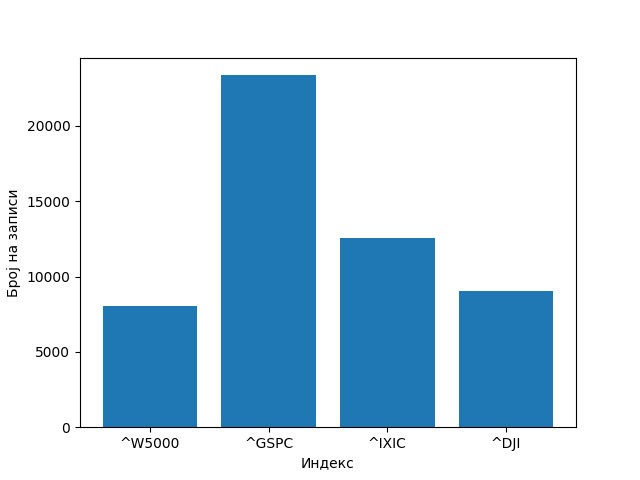

In [6]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np


def plot_counts(df, cols, xlabel, show_x_ticks=True, sort_by_count=False):
    counts = [len(df.xs(col, level=1, axis=1).dropna()) for col in cols]
    if sort_by_count:
        counts, cols = zip(*sorted(zip(counts, cols)))

    ticks = np.arange(len(counts))
    plt.bar(ticks, counts)
    if show_x_ticks:
        plt.xticks(ticks, cols)

    plt.xlabel(xlabel)
    plt.ylabel("Број на записи")
    plt.show(block=False)


plot_counts(daily_data_indexes, indexes, "Индекс")

Индексот S&P 500 e значително постар од другите индекси, има значително повеќе податоци и самиот е составен од најголем број на акции (над 500), ако не се земе предвид индексот The Wilshire 5000 кој ги содржи речиси сите акции од пазарот на САД. Затоа S&P 500 можеме да го користиме за повеќето анализи што ќе ги правиме (на пр. споредба на средни прирасти по денови).

Сега да погледнеме колку податоци имаат различните акции. Бидејќи станува збор за 532 акции, нивните имиња нема да ги прикажеме на x оската.

<IPython.core.display.Javascript object>


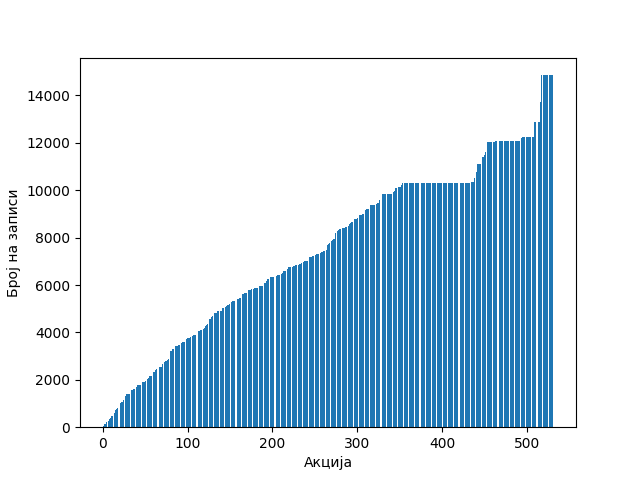

In [7]:
plot_counts(daily_data_tickers,
            all_tickers,
            "Акција",
            show_x_ticks=False,
            sort_by_count=True)

Во просек, берзата е отворена околу 250 дена годишно (365 - викенди (2 * 52 = 104) - празници = 261 - празници ~ 250 дена). Од графикот можеме да забележиме дека имаме акции кои се стари и над 56 години (> 14000 записи). Повеќе од пола од акциите се постари од 30 години, а околу 80% се постари од 10 години.

Сега графички ќе прикажеме колкав процент од акциите кои ни се на располагање се помлади од 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60 години. Исто така, графички ќе прикажеме колку од акциите кои се располагање имаат старост помеѓу 0 и 1 година, 1 и 5 години, 5 и 10 години, 10 и 15 години итн.

<IPython.core.display.Javascript object>


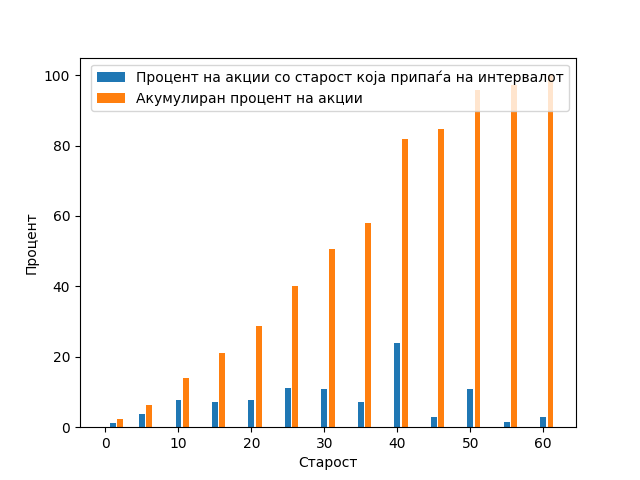

In [8]:
def calc_years_age(df):
    return int((df.index[-1] - df.index[0]).days / 365)


def plot_ticker_age(df, cols, ages, age_calculator):
    total = len(cols)
    pcts = [0 for age in ages]
    cummulative_pcts = [0 for age in ages]
    for col in cols:
        age = age_calculator(df.xs(col, level=1, axis=1).dropna())
        for x in range(len(ages) - 1):
            if age > ages[x] and age <= ages[x + 1]:
                pcts[x + 1] += 100 / total

            if age <= ages[x + 1]:
                cummulative_pcts[x + 1] += 100 / total

    plt.bar(ages,
            pcts,
            label="Процент на акции со старост која припаѓа на интервалот")
    plt.bar([age + 1 for age in ages],
            cummulative_pcts,
            label="Акумулиран процент на акции")
    plt.xlabel("Старост")
    plt.ylabel("Процент")
    plt.legend()
    plt.show()


plot_ticker_age(daily_data_tickers,
                all_tickers,
                ages=[0, 1] + list(range(5, 61, 5)),
                age_calculator=calc_years_age)

Јасно е дека не можеме само едноставно да направиме `.dropna` на дневните податоци, бидејќи така ќе изгубиме над 55 години записи. Од друга страна, не можеме ниту да си дозволиме да ги пополниме вредностите кои недостасуваар со средни вредности или со некој регресионен модел. Затоа, најлесен начин на кој можеме да работиме со овие податоци е да ги поделиме на групи од кои ќе моежеме да задржиме онолку записи колку што има најмладата акција во таа група. Ако случајно некој запис недостига и после ова филтрирање, истиот ќе го интерполираме.

Групите би биле:
- група на акции постари од 1 година - околу 250 записи, речиси 100% од акциите, би ја опфатиле ковид кризата
- група на акции постари од 10 години - околу 2500 записи, над 80% од акциите, би го опфатиле пазарот после кризата во 2008
- група на акции постари од 20 години - околу 5000 записи, над 75% од акциите, би го опфатиле подемот на социјалните мрежи и други технолошки гиганти
- група на акции постара од 30 години - околу 7500 записи, речиси 50% од акциите, би го опфатиле пазарот после падот на Берлинскиот ѕид и воведувањето на неолибералните реформи на Тачер и Реган (trickle-down economics)
- група на акции постара од 40 години - околу 10000 записи, над 35% од акциите
- група на акции постара од 50 години - околу 12500 записи, околу 5% од акциите

In [9]:
def get_df_for_older_than(df, cols, age, age_calculator):
    counts = [len(df.xs(col, level=1, axis=1).dropna()) for col in cols]
    ages = [age_calculator(df.xs(col, level=1, axis=1).dropna()) for col in cols]
    older_cols_counts = [(col, count)
                         for col, col_age, count in zip(cols, ages, counts)
                         if col_age >= age]
    older_cols = [item[0] for item in older_cols_counts]
    min_rows = min([item[1] for item in older_cols_counts])
    df_cols = [col for col in df.columns if col[1] in older_cols]
    filtered_df = df[df_cols]
    return df[df_cols].iloc[-min_rows:].interpolate()


one_year_daily_tickers = get_df_for_older_than(daily_data_tickers,
                                               all_tickers,
                                               age=1,
                                               age_calculator=calc_years_age)
one_year_daily_tickers

Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2019-12-05   81.529999  27.240000  152.289993   66.394997   86.720001   
2019-12-06   82.209999  27.730000  154.619995   67.677498   86.980003   
2019-12-09   81.620003  27.490000  151.570007   66.730003   86.440002   
2019-12-10   82.930000  27.000000  156.169998   67.120003   86.559998   
2019-12-11   83.419998  26.860001  155.899994   67.692497   86.699997   
...                ...        ...         ...         ...         ...   
2020-12-24  117.309998  15.660000  160.679993  131.970001  103.260002   
2020-12-28  117.830002  16.059999  158.800003  136.690002  103.449997   
2020-12-29  117.230003  15.860000  156.690002  134.869995  104.699997   
2020-12-30  117.389999  16.150000  157.660004  133.720001  105.269997   
2020-12-31  118.489998  15.770000  157.509995  132.690002  107.150002   

                                                                       ...  \
                  ABC        ABMD         ABT         ACN        ADBE  ...   
Date                                                                   ...   
2019-12-05  87.820000  189.070007   85.239998  199.850006  303.029999  ...   
2019-12-06  88.239998  189.220001   85.480003  202.550003  306.230011  ...   
2019-12-09  86.389999  181.690002   83.870003  202.029999  307.049988  ...   
2019-12-10  86.760002  179.750000   84.559998  201.880005  304.170013  ...   
2019-12-11  86.660004  178.869995   84.910004  202.300003  303.739990  ...   
...               ...         ...         ...         ...         ...  ...   
2020-12-24  96.970001  303.410004  108.349998  257.299988  499.859985  ...   
2020-12-28  96.800003  312.910004  107.790001  259.679993  498.950012  ...   
2020-12-29  97.120003  320.929993  108.330002  257.760010  502.109985  ...   
2020-12-30  96.959999  323.920013  108.440002  257.540009  497.450012  ...   
2020-12-31  97.760002  324.200012  109.489998  261.209991  500.119995  ...   

               Volume                                                          \
                 XLNX         XOM       XRAY        XRX        XYL        YUM   
Date                                                                            
2019-12-05  2440800.0  13109000.0  1435200.0  2357400.0  1273200.0  2184600.0   
2019-12-06  2286600.0  13710800.0  1200000.0  1826100.0   981300.0  1951300.0   
2019-12-09  2406600.0  12397700.0   954400.0  2851900.0  1082000.0  1796700.0   
2019-12-10  3276000.0  14281800.0   896300.0  3814500.0   911400.0  1775100.0   
2019-12-11  3009100.0  13748400.0  1781300.0  1766100.0   665600.0  1675700.0   
...               ...         ...        ...        ...        ...        ...   
2020-12-24  1167500.0   8039000.0   217600.0   940500.0   249700.0   340400.0   
2020-12-28  1978500.0  23877500.0   576400.0  1903300.0   408600.0  1822900.0   
2020-12-29  1489900.0  20287700.0   458300.0  1488500.0   501900.0  1818300.0   
2020-12-30  2892600.0  23807300.0   527500.0  1092600.0   418200.0  1267900.0   
2020-12-31  1236100.0  22769300.0   607100.0  1514100.0   504200.0  1651700.0   

                                                      
                 ZBH      ZBRA       ZION        ZTS  
Date                                                  
2019-12-05  867700.0  355900.0  1271600.0  2771100.0  
2019-12-06  707400.0  461400.0  1805000.0  2387200.0  
2019-12-09  613400.0  371700.0  1170800.0  1570800.0  
2019-12-10  875100.0  296700.0  1463500.0  2047000.0  
2019-12-11  691700.0  374500.0  1156900.0  1803000.0  
...              ...       ...        ...        ...  
2020-12-24  283800.0  138300.0   327700.0   417400.0  
2020-12-28  684000.0  251200.0   835600.0  1522400.0  
2020-12-29  735700.0  185500.0  1084100.0  1188400.0  
2020-12-30  427600.0  166100.0   728400.0  1009000.0  
2020-12-31  499200.0  176500.0   736300.0  1292600.

In [10]:
ten_year_daily_tickers = get_df_for_older_than(daily_data_tickers,
                                               all_tickers,
                                               age=10,
                                               age_calculator=calc_years_age)
ten_year_daily_tickers

Close                                                \
                     A        AAL         AAP        AAPL        ABC   
Date                                                                   
2010-12-23   29.377682   9.910000   66.570000   11.557143  34.400002   
2010-12-27   29.985693   9.870000   66.419998   11.595715  34.299999   
2010-12-28   29.692417   9.890000   66.250000   11.623929  34.189999   
2010-12-29   29.821173  10.140000   66.449997   11.617500  34.639999   
2010-12-30   29.749641  10.130000   66.720001   11.559286  34.220001   
...                ...        ...         ...         ...        ...   
2020-12-24  117.309998  15.660000  160.679993  131.970001  96.970001   
2020-12-28  117.830002  16.059999  158.800003  136.690002  96.800003   
2020-12-29  117.230003  15.860000  156.690002  134.869995  97.120003   
2020-12-30  117.389999  16.150000  157.660004  133.720001  96.959999   
2020-12-31  118.489998  15.770000  157.509995  132.690002  97.760002   

                                                                        ...  \
                  ABMD         ABT         ACN        ADBE         ADI  ...   
Date                                                                    ...   
2010-12-23    9.560000   22.939238   48.340000   30.850000   37.669998  ...   
2010-12-27    9.750000   22.732924   48.250000   30.950001   38.119999  ...   
2010-12-28    9.770000   22.737722   47.980000   30.920000   37.549999  ...   
2010-12-29    9.850000   22.752115   48.619999   30.969999   37.639999  ...   
2010-12-30    9.710000   22.824085   48.419998   30.570000   37.959999  ...   
...                ...         ...         ...         ...         ...  ...   
2020-12-24  303.410004  108.349998  257.299988  499.859985  144.470001  ...   
2020-12-28  312.910004  107.790001  259.679993  498.950012  144.679993  ...   
2020-12-29  320.929993  108.330002  257.760010  502.109985  143.660004  ...   
2020-12-30  323.920013  108.440002  257.540009  497.450012  146.179993  ...   
2020-12-31  324.200012  109.489998  261.209991  500.119995  147.729996  ...   

               Volume                                                         \
                 WYNN        XEL       XLNX         XOM      XRAY        XRX   
Date                                                                           
2010-12-23   950300.0  1349100.0  5827600.0  11390900.0  312800.0  1327100.0   
2010-12-27  1049200.0  1623200.0  3037500.0   9757200.0  545500.0  1862800.0   
2010-12-28   718400.0  1258400.0  2815000.0  14423400.0  460000.0  2807600.0   
2010-12-29  1719900.0   901700.0  2418400.0  11797700.0  419600.0  2287300.0   
2010-12-30   784100.0  1375300.0  2387500.0  10790400.0  413000.0  2301900.0   
...               ...        ...        ...         ...       ...        ...   
2020-12-24   850900.0   598400.0  1167500.0   8039000.0  217600.0   940500.0   
2020-12-28  1912000.0  1799800.0  1978500.0  23877500.0  576400.0  1903300.0   
2020-12-29  1262500.0  1761400.0  1489900.0  20287700.0  458300.0  1488500.0   
2020-12-30  2087100.0  1296400.0  2892600.0  23807300.0  527500.0  1092600.0   
2020-12-31  2103400.0  1743300.0  1236100.0  22769300.0  607100.0  1514100.0   

                                                      
                  YUM       ZBH      ZBRA       ZION  
Date                                                  
2010-12-23  2268700.0  888100.0  131700.0  3038100.0  
2010-12-27  1395000.0  579000.0  128500.0  2567700.0  
2010-12-28  2058400.0  770600.0  215200.0  2670800.0  
2010-12-29  2452800.0  606400.0  117200.0  1761700.0  
2010-12-30  1676400.0  679700.0  112900.0  1260600.0  
...               ...       ...       ...        ...  
2020-12-24   340400.0  283800.0  138300.0   327700.0  
2020-12-28  1822900.0  684000.0  251200.0   835600.0  
2020-12-29  1818300.0  735700.0  185500.0  1084100.0  
2020-12-30  1267900.0  427600.0  166100.0   728400.0  
2020-12-31  1651700.0  499200.0  176500.0   736300.0  

[2529 row

In [11]:
twenty_year_daily_tickers = get_df_for_older_than(
    daily_data_tickers, all_tickers, age=20, age_calculator=calc_years_age)
twenty_year_daily_tickers

Close                                                 \
                     A        AAPL        ABC        ABMD         ABT   
Date                                                                    
2000-12-21   36.748928    0.251116  12.078125   24.625000   21.603355   
2000-12-22   39.118382    0.267857  12.484375   27.812500   21.266680   
2000-12-26   38.268955    0.262277  12.656250   25.000000   21.631411   
2000-12-27   40.012516    0.264509  12.953125   25.875000   21.799749   
2000-12-28   39.565449    0.264509  13.156250   25.250000   21.771692   
...                ...         ...        ...         ...         ...   
2020-12-24  117.309998  131.970001  96.970001  303.410004  108.349998   
2020-12-28  117.830002  136.690002  96.800003  312.910004  107.790001   
2020-12-29  117.230003  134.869995  97.120003  320.929993  108.330002   
2020-12-30  117.389999  133.720001  96.959999  323.920013  108.440002   
2020-12-31  118.489998  132.690002  97.760002  324.200012  109.489998   

                                                                       ...  \
                  ADBE         ADI        ADM         ADP        ADSK  ...   
Date                                                                   ...   
2000-12-21   29.906250   47.437500  13.273809   46.790783    6.031250  ...   
2000-12-22   32.843750   49.250000  13.154762   47.187313    6.023438  ...   
2000-12-26   32.968750   51.625000  13.333333   48.525608    5.968750  ...   
2000-12-27   32.750000   55.562500  13.630953   49.814339    6.187500  ...   
2000-12-28   30.812500   54.000000  13.928572   50.260437    6.625000  ...   
...                ...         ...        ...         ...         ...  ...   
2020-12-24  499.859985  144.470001  49.439999  176.559998  301.390015  ...   
2020-12-28  498.950012  144.679993  49.700001  176.610001  299.649994  ...   
2020-12-29  502.109985  143.660004  49.450001  174.869995  298.109985  ...   
2020-12-30  497.450012  146.179993  49.910000  173.809998  299.410004  ...   
2020-12-31  500.119995  147.729996  50.410000  176.199997  305.339996  ...   

              Volume                                                           \
                 WST         WY        XEL        XLNX         XOM       XRAY   
Date                                                                            
2000-12-21    9600.0  1507600.0   574200.0  10090000.0  12695400.0  1025400.0   
2000-12-22   40800.0  1073400.0   551700.0   9779200.0   8543200.0   431000.0   
2000-12-26   13600.0   862100.0   544700.0   4633600.0   5580600.0   289400.0   
2000-12-27  114400.0   883800.0   476300.0   6379600.0  10437800.0  1246400.0   
2000-12-28   70800.0   786200.0   354400.0   5775500.0  10854600.0  1548600.0   
...              ...        ...        ...         ...         ...        ...   
2020-12-24  147100.0  1135400.0   598400.0   1167500.0   8039000.0   217600.0   
2020-12-28  213100.0  2541700.0  1799800.0   1978500.0  23877500.0   576400.0   
2020-12-29  222700.0  1988100.0  1761400.0   1489900.0  20287700.0   458300.0   
2020-12-30  233700.0  2128900.0  1296400.0   2892600.0  23807300.0   527500.0   
2020-12-31  455600.0  2633400.0  1743300.0   1236100.0  22769300.0   607100.0   

                                                       
                  XRX        YUM      ZBRA       ZION  
Date                                                   
2000-12-21  6121900.0  9095400.0  804100.0   455400.0  
2000-12-22  4351000.0  4471200.0  590400.0  1029700.0  
2000-12-26  2900800.0  2509300.0  432100.0   126200.0  
2000-12-27  4377900.0  3016200.0  941800.0   157900.0  
2000-12-28  4475700.0  3512500.0  602100.0   381300.0  
...               ...        ...       ...        ...  
2020-12-24   940500.0   340400.0  138300.0   327700.0  
2020-12-28  1903300.0  1822900.0  251200.0   835600.0  
2020-12-29  1488500.0  1818300.0  185500.0  1084100.0  
2020-12-30  1092600.0  1267900.0  166100.0   728400.0  
2020-12-31  1514100.0  1651700.0  1765

In [12]:
thirty_year_daily_tickers = get_df_for_older_than(
    daily_data_tickers, all_tickers, age=30, age_calculator=calc_years_age)
thirty_year_daily_tickers

Close                                                  \
                  AAPL        ABMD         ABT        ADBE         ADI   
Date                                                                     
1990-07-11    0.419643    4.812500    4.909853    2.390625    1.208333   
1990-07-12    0.422991    4.875000    4.895825    2.343750    1.208333   
1990-07-13    0.417411    4.812500    4.895825    2.375000    1.187500   
1990-07-16    0.407366    4.875000    4.979994    2.406250    1.208333   
1990-07-17    0.395089    4.937500    5.036107    2.343750    1.208333   
...                ...         ...         ...         ...         ...   
2020-12-24  131.970001  303.410004  108.349998  499.859985  144.470001   
2020-12-28  136.690002  312.910004  107.790001  498.950012  144.679993   
2020-12-29  134.869995  320.929993  108.330002  502.109985  143.660004   
2020-12-30  133.720001  323.920013  108.440002  497.450012  146.179993   
2020-12-31  132.690002  324.200012  109.489998  500.119995  147.729996   

                                                                     ...  \
                  ADM         ADP        ADSK        AEP        AFL  ...   
Date                                                                 ...   
1990-07-11   9.559042    5.588624    7.312500  29.375000   1.116667  ...   
1990-07-12   9.791058    5.687757    7.312500  29.375000   1.108333  ...   
1990-07-13   9.605446    5.737323    7.312500  29.375000   1.125000  ...   
1990-07-16   9.373430    5.836456    7.500000  29.500000   1.133333  ...   
1990-07-17   9.419833    5.972764    7.281250  29.500000   1.141667  ...   
...               ...         ...         ...        ...        ...  ...   
2020-12-24  49.439999  176.559998  301.390015  81.419998  43.840000  ...   
2020-12-28  49.700001  176.610001  299.649994  81.279999  43.919998  ...   
2020-12-29  49.450001  174.869995  298.109985  81.180000  43.750000  ...   
2020-12-30  49.910000  173.809998  299.410004  81.510002  44.009998  ...   
2020-12-31  50.410000  176.199997  305.339996  83.269997  44.470001  ...   

                Volume                                                        \
                   WMT        WRB       WST         WY        XEL       XLNX   
Date                                                                           
1990-07-11  14936800.0   198600.0  125200.0   178200.0    70200.0  1683600.0   
1990-07-12  11392400.0   535900.0  287600.0   372600.0   125800.0  4863600.0   
1990-07-13  12762400.0  2100700.0  126000.0   210200.0   253800.0  3573600.0   
1990-07-16  12465200.0   786600.0   76000.0   409100.0   314400.0  4029600.0   
1990-07-17  10642400.0   191200.0   38000.0   224600.0   248800.0  2526000.0   
...                ...        ...       ...        ...        ...        ...   
2020-12-24   3018200.0   149500.0  147100.0  1135400.0   598400.0  1167500.0   
2020-12-28   6448300.0   539300.0  213100.0  2541700.0  1799800.0  1978500.0   
2020-12-29   5979400.0   398000.0  222700.0  1988100.0  1761400.0  1489900.0   
2020-12-30   6250400.0   365700.0  233700.0  2128900.0  1296400.0  2892600.0   
2020-12-31   5933600.0   749400.0  455600.0  2633400.0  1743300.0  1236100.0   

                                                        
                   XOM      XRAY        XRX       ZION  
Date                                                    
1990-07-11   4042400.0  306000.0   386400.0    96000.0  
1990-07-12   6298400.0  210000.0  1124100.0   128800.0  
1990-07-13   8439200.0  194400.0   730400.0    23200.0  
1990-07-16   3851600.0  300000.0   544200.0    31200.0  
1990-07-17   5114000.0  811200.0   828600.0    17600.0  
...                ...       ...        ...        ...  
2020-12-24   8039000.0  217600.0   940500.0   327700.0  
2020-12-28  23877500.0  576400.0  1903300.0   835600.0  
2020-12-29  20287700.0  458300.0  1488500.0  1084100.0  
2020-12-30  23807300.0  527500.0  1092600.0   728400.0  
2020-12-31  22769300.0  607100.0  1514100.0   736300.

In [13]:
fourty_year_daily_tickers = get_df_for_older_than(
    daily_data_tickers, all_tickers, age=40, age_calculator=calc_years_age)
fourty_year_daily_tickers

Close                                                 \
                  AAPL         ABT         ADI        ADM         ADP   
Date                                                                    
1981-01-14    0.136719    0.797851    1.245000   2.552479    1.214379   
1981-01-15    0.139509    0.782070    1.340000   2.570204    1.208184   
1981-01-16    0.138393    0.790837    1.345000   2.508165    1.208184   
1981-01-19    0.146763    0.797851    1.370000   2.463851    1.226771   
1981-01-20    0.142299    0.782070    1.345000   2.419537    1.201988   
...                ...         ...         ...        ...         ...   
2020-12-24  131.970001  108.349998  144.470001  49.439999  176.559998   
2020-12-28  136.690002  107.790001  144.679993  49.700001  176.610001   
2020-12-29  134.869995  108.330002  143.660004  49.450001  174.869995   
2020-12-30  133.720001  108.440002  146.179993  49.910000  173.809998   
2020-12-31  132.690002  109.489998  147.729996  50.410000  176.199997   

                                                                   ...  \
                  AEP        AFL        AIG        ALK       AMAT  ...   
Date                                                               ...   
1981-01-14  17.625000   0.102588  32.925323   0.952381   0.217448  ...   
1981-01-15  17.625000   0.101010  32.812950   0.952381   0.220052  ...   
1981-01-16  17.750000   0.101010  33.037697   0.952381   0.220052  ...   
1981-01-19  17.750000   0.101010  33.150070   0.952381   0.222656  ...   
1981-01-20  17.625000   0.101010  33.037697   0.952381   0.214844  ...   
...               ...        ...        ...        ...        ...  ...   
2020-12-24  81.419998  43.840000  37.369999  52.250000  85.330002  ...   
2020-12-28  81.279999  43.919998  37.070000  52.580002  84.870003  ...   
2020-12-29  81.180000  43.750000  37.160000  52.029999  84.269997  ...   
2020-12-30  81.510002  44.009998  37.520000  52.900002  86.980003  ...   
2020-12-31  83.269997  44.470001  37.860001  52.000000  86.300003  ...   

                Volume                                                      \
                   WFC       WHR        WMT       WRB       WST         WY   
Date                                                                         
1981-01-14   1211200.0   95400.0  1331200.0   10900.0  177600.0    47400.0   
1981-01-15    768000.0   29200.0   281600.0   10900.0  107200.0   240300.0   
1981-01-16    347200.0   57400.0  3942400.0       0.0  123200.0    82900.0   
1981-01-19    923200.0  134200.0   755200.0    9400.0   36800.0    87300.0   
1981-01-20   3073600.0   32200.0  2278400.0   62100.0   57600.0    72900.0   
...                ...       ...        ...       ...       ...        ...   
2020-12-24  14443700.0  302600.0  3018200.0  149500.0  147100.0  1135400.0   
2020-12-28  21658500.0  571800.0  6448300.0  539300.0  213100.0  2541700.0   
2020-12-29  19584400.0  399200.0  5979400.0  398000.0  222700.0  1988100.0   
2020-12-30  18519300.0  373100.0  6250400.0  365700.0  233700.0  2128900.0   
2020-12-31  21066300.0  534400.0  5933600.0  749400.0  455600.0  2633400.0   

                                                         
                  XEL         XOM        XRX       ZION  
Date                                                     
1981-01-14    97200.0   3953600.0   396600.0    19200.0  
1981-01-15   124400.0   3691200.0   398900.0        0.0  
1981-01-16    81600.0   5105600.0   566700.0    10400.0  
1981-01-19    57600.0   2507200.0   383600.0    14400.0  
1981-01-20   119600.0   3225600.0   497900.0    33600.0  
...               ...         ...        ...        ...  
2020-12-24   598400.0   8039000.0   940500.0   327700.0  
2020-12-28  1799800.0  23877500.0  1903300.0   835600.0  
2020-12-29  1761400.0  20287700.0  1488500.0  1084100.0  
2020-12-30  1296400.0  23807300.0  1092600.0   728400.0  
2020-12-31  1743300.0  22769300.0  1514100.0   736300.0  

[10099 rows x 935 columns]

In [14]:
fifty_year_daily_tickers = get_df_for_older_than(daily_data_tickers,
                                                 all_tickers,
                                                 age=50,
                                                 age_calculator=calc_years_age)
fifty_year_daily_tickers

Close                                                \
                  AEP          BA         CAT        CNP        CVX   
Date                                                                  
1970-01-30  27.750000    0.757202    3.031250  10.467250   2.882812   
1970-02-02  28.250000    0.732510    3.041667  10.467250   2.875000   
1970-02-03  28.375000    0.748971    3.104167  10.572625   2.851562   
1970-02-04  28.250000    0.716049    3.062500  10.642875   2.875000   
1970-02-05  28.000000    0.699588    3.041667  10.502375   2.875000   
...               ...         ...         ...        ...        ...   
2020-12-24  81.419998  217.149994  179.559998  21.580000  85.330002   
2020-12-28  81.279999  216.089996  178.369995  21.410000  84.900002   
2020-12-29  81.180000  216.250000  176.649994  21.299999  84.610001   
2020-12-30  81.510002  216.669998  180.039993  21.420000  85.330002   
2020-12-31  83.269997  214.059998  182.020004  21.639999  84.449997   

                                                                      ...  \
                   DIS         DTE         ED         GE         HON  ...   
Date                                                                  ...   
1970-01-30    0.728314   21.375000   6.750000   0.724910    3.734031  ...   
1970-02-02    0.736021   21.500000   6.750000   0.732422    3.773754  ...   
1970-02-03    0.736021   21.500000   6.687500   0.727414    3.813478  ...   
1970-02-04    0.746298   21.750000   6.750000   0.727414    3.714169  ...   
1970-02-05    0.738590   21.875000   6.687500   0.699870    3.654583  ...   
...                ...         ...        ...        ...         ...  ...   
2020-12-24  173.729996  119.720001  70.440002  10.650000  209.529999  ...   
2020-12-28  178.860001  119.230003  71.260002  10.640000  209.940002  ...   
2020-12-29  177.300003  119.239998  70.760002  10.560000  209.130005  ...   
2020-12-30  181.169998  119.660004  71.019997  10.710000  210.949997  ...   
2020-12-31  181.179993  121.410004  72.269997  10.800000  212.699997  ...   

               Volume                                                         \
                  JNJ         KO        MCD        MMM         MO        MRK   
Date                                                                           
1970-01-30  2808000.0   777600.0  2971200.0   430400.0  1488000.0  1454400.0   
1970-02-02  1612800.0  2025600.0  3651200.0   340800.0   787200.0   813600.0   
1970-02-03  2692800.0  1440000.0  4040000.0   692800.0  1142400.0  2181600.0   
1970-02-04  2793600.0  1516800.0  1440800.0   392000.0   547200.0  1476000.0   
1970-02-05  1886400.0  1286400.0   324000.0   292800.0  8361600.0   489600.0   
...               ...        ...        ...        ...        ...        ...   
2020-12-24  2114900.0  3265500.0  1047700.0   656200.0  6055800.0  2822000.0   
2020-12-28  3855500.0  9020500.0  2550100.0  1403000.0  8657900.0  4584200.0   
2020-12-29  5212000.0  8320600.0  1665700.0  1218900.0  8979600.0  5446600.0   
2020-12-30  5412800.0  8142700.0  1855000.0  1419100.0  7038700.0  5661600.0   
2020-12-31  5098600.0  8493700.0  2610200.0  1840900.0  7286300.0  5257100.0   

                                                          
                   MRO         PG        RTX         XOM  
Date                                                      
1970-01-30    139100.0   435200.0   432200.0   2172800.0  
1970-02-02    149800.0  2451200.0   437200.0   2755200.0  
1970-02-03    150800.0  1235200.0   818600.0   2572800.0  
1970-02-04    122000.0   384000.0   783000.0   2003200.0  
1970-02-05    140100.0   454400.0   254200.0   1676800.0  
...                ...        ...        ...         ...  
2020-12-24  15690700.0  2588200.0  1758600.0   8039000.0  
2020-12-28  15446800.0  3714700.0  2938000.0  23877500.0  
2020-12-29  16760000.0  5139300.0  3670100.0  20287700.0  
2020-12-30  19212900.0  3261400.0  5015500.0  23807300.0  
2020-12-31  17263900.0  4073700.0  4158400.0  22769300

## Intraday податоци

Од овие податоци имаме податоци само од претходниот месец. Кај индексите можеме да се увериме дека не недостигаат многу податоци и дека можеме истите да ги интерполираме.

In [15]:
len(intraday_data_indexes), len(intraday_data_indexes.dropna())

(1602, 1599)

In [16]:
intraday_data_indexes = intraday_data_indexes.interpolate()
intraday_data_indexes

Close                             \
                                   ^DJI        ^GSPC         ^IXIC   
Datetime                                                             
2020-12-02 09:30:00-05:00  29619.109375  3647.429932  12250.054688   
2020-12-02 09:35:00-05:00  29685.539062  3651.439941  12250.332031   
2020-12-02 09:40:00-05:00  29686.210938  3646.780029  12225.235352   
2020-12-02 09:45:00-05:00  29690.179688  3646.949951  12224.831055   
2020-12-02 09:50:00-05:00  29727.759766  3654.010010  12251.446289   
...                                 ...          ...           ...   
2020-12-31 15:35:00-05:00  30552.609375  3747.729980  12865.577148   
2020-12-31 15:40:00-05:00  30536.160156  3746.659912  12866.172852   
2020-12-31 15:45:00-05:00  30572.810547  3750.340088  12869.606445   
2020-12-31 15:50:00-05:00  30592.970703  3754.870117  12885.341797   
2020-12-31 15:55:00-05:00  30604.640625  3756.310059  12890.033203   

                                                 High               \
                                 ^W5000          ^DJI        ^GSPC   
Datetime                                                             
2020-12-02 09:30:00-05:00  37933.738281  29695.089844  3653.780029   
2020-12-02 09:35:00-05:00  37998.105469  29699.880859  3653.919922   
2020-12-02 09:40:00-05:00  37959.695312  29729.130859  3653.719971   
2020-12-02 09:45:00-05:00  37957.632812  29714.339844  3649.530029   
2020-12-02 09:50:00-05:00  38024.414062  29742.660156  3655.179932   
...                                 ...           ...          ...   
2020-12-31 15:35:00-05:00  39404.324219  30574.880859  3750.189941   
2020-12-31 15:40:00-05:00  39394.039062  30552.880859  3747.760010   
2020-12-31 15:45:00-05:00  39416.378906  30575.589844  3750.639893   
2020-12-31 15:50:00-05:00  39461.378906  30610.759766  3756.129883   
2020-12-31 15:55:00-05:00  39482.648438  30637.470703  3760.199951   

                                                                Low  \
                                  ^IXIC        ^W5000          ^DJI   
Datetime                                                              
2020-12-02 09:30:00-05:00  12287.589844  38194.109375  29599.289062   
2020-12-02 09:35:00-05:00  12260.757812  38017.285156  29615.140625   
2020-12-02 09:40:00-05:00  12254.869141  38023.621094  29671.769531   
2020-12-02 09:45:00-05:00  12236.326172  37978.082031  29655.050781   
2020-12-02 09:50:00-05:00  12251.446289  38028.144531  29684.099609   
...                                 ...           ...           ...   
2020-12-31 15:35:00-05:00  12868.369141  39420.046875  30552.189453   
2020-12-31 15:40:00-05:00  12866.998047  39403.273438  30526.320312   
2020-12-31 15:45:00-05:00  12869.747070  39416.378906  30533.119141   
2020-12-31 15:50:00-05:00  12889.518555  39469.128906  30559.240234   
2020-12-31 15:55:00-05:00  12902.073242  39482.648438  30576.289062   

                                                                    \
                                 ^GSPC         ^IXIC        ^W5000   
Datetime                                                             
2020-12-02 09:30:00-05:00  3645.699951  12247.467773  37919.292969   
2020-12-02 09:35:00-05:00  3647.429932  12236.573242  37925.851562   
2020-12-02 09:40:00-05:00  3646.780029  12223.703125  37958.972656   
2020-12-02 09:45:00-05:00  3644.840088  12222.209961  37939.898438   
2020-12-02 09:50:00-05:00  3645.620117  12217.823242  37935.468750   
...                                ...           ...           ...   
2020-12-31 15:35:00-05:00  3747.580078  12861.677734  39398.902344   
2020-12-31 15:40:00-05:00  3745.020020  12859.122070  39375.929688   
2020-12-31 15:45:00-05:00  3746.399902  12861.031250  39392.386719   
2020-12-31 15:50:00-05:00  3749.050049  12879.404297  39423.222656   
2020-12-31 15:55:00-05:00  3752.760010  12880.004883  39429.843750   

                                   Open                             \
                          

Кај акциите не е истиот случај, па мораме да направиме слична анализа како кај дневните податоци.

In [17]:
len(intraday_data_tickers), len(intraday_data_tickers.dropna())

(1600, 21)

<IPython.core.display.Javascript object>


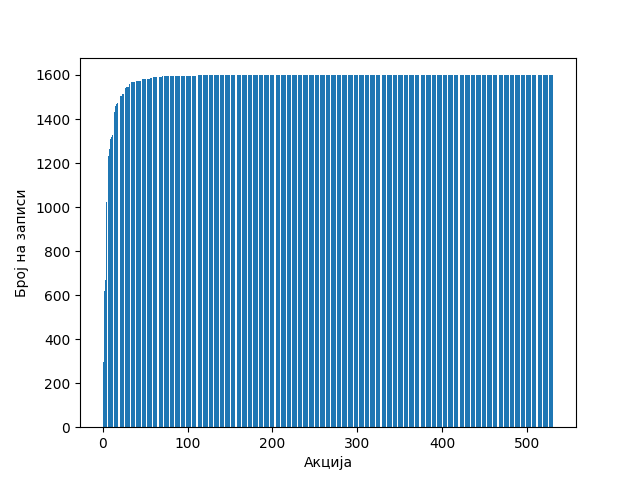

In [18]:
plot_counts(intraday_data_tickers,
            all_tickers,
            "Акција",
            show_x_ticks=False,
            sort_by_count=True)

Во овој случај ни е полесно едноставно да ги отфрлиме оние акции кои немаат доволно податоци, бидејќи се малку на број. податоците се на 5 минути, а пазарот e отворен 6.5 часа = 390 минути = 78 * 5 минути. Ова ќе го искористиме за да ја пресметаме староста, со цел да ги искористиме веќе постоечките функции. Забележете како функцијата `calc_days_age` не ја пресметува вистинската старост, туку пресметува колку денови може бројот на податоци кои остануваат да пополнат. Ова го правиме вака бидејќи поголем дел од податоците не недостигаат на почетокот, туку се распрскани во средината, и стариот метод на пресметување на старост нема да го даде посакуваниот резултат.

<IPython.core.display.Javascript object>


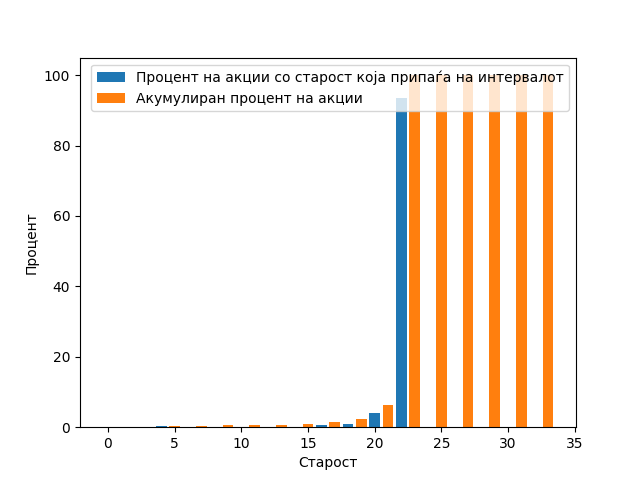

In [19]:
def calc_days_age(df):
    return len(df) / 78

plot_ticker_age(intraday_data_tickers,
                all_tickers,
                ages=list(range(0, 33, 2)),
                age_calculator=calc_days_age)

Ако ги задржиме само акциите постари од 20 дена, ќе задржиме над 95% од акциите и 95% од записите (иако месецот има 30 дена, дали 22 дена од нив се навистина денови кога е отворен пазарот). Доколку некои податоци измеѓу фалат (понекогаш се случува), ќе ги интерполираме.

In [20]:
intraday_data_tickers = get_df_for_older_than(intraday_data_tickers,
                                              all_tickers,
                                              age=20,
                                              age_calculator=calc_days_age)
intraday_data_tickers

Close                                   \
                                    A      AAL         AAP        AAPL   
Datetime                                                                 
2020-12-02 12:45:00-05:00  114.785004  14.5950  148.830002  123.019997   
2020-12-02 12:50:00-05:00  114.889999  14.6341  148.899994  123.074997   
2020-12-02 12:55:00-05:00  114.885002  14.6050  148.535004  122.915001   
2020-12-02 13:00:00-05:00  114.889999  14.6250  148.419998  122.859001   
2020-12-02 13:05:00-05:00  114.900002  14.6464  148.154999  123.055000   
...                               ...      ...         ...         ...   
2020-12-31 15:35:00-05:00  118.099998  15.8500  157.315002  132.750000   
2020-12-31 15:40:00-05:00  118.169998  15.8250  157.255005  132.725006   
2020-12-31 15:45:00-05:00  118.269997  15.8050  157.350006  132.610001   
2020-12-31 15:50:00-05:00  118.349998  15.7950  157.460007  132.589996   
2020-12-31 15:55:00-05:00  118.430000  15.7550  157.509995  132.580002   

                                                                           \
                                 ABBV         ABC        ABMD         ABT   
Datetime                                                                    
2020-12-02 12:45:00-05:00  104.598000  103.430000  267.519989  108.009903   
2020-12-02 12:50:00-05:00  104.629997  103.410004  267.320007  108.035004   
2020-12-02 12:55:00-05:00  104.660004  103.510002  267.179993  108.095001   
2020-12-02 13:00:00-05:00  104.650002  103.480003  266.765015  108.150002   
2020-12-02 13:05:00-05:00  104.580002  103.279999  266.269989  108.099998   
...                               ...         ...         ...         ...   
2020-12-31 15:35:00-05:00  106.949997   97.489998  322.445007  109.290001   
2020-12-31 15:40:00-05:00  106.889999   97.519897  322.799988  109.230003   
2020-12-31 15:45:00-05:00  106.989998   97.580002  322.545013  109.360001   
2020-12-31 15:50:00-05:00  107.095001   97.779999  325.149994  109.449997   
2020-12-31 15:55:00-05:00  107.029999   97.720001  324.299988  109.440002   

                                                  ...    Volume             \
                                ACCD         ACN  ...      XLNX        XOM   
Datetime                                          ...                        
2020-12-02 12:45:00-05:00  51.270000  248.410004  ...   14540.0   319274.0   
2020-12-02 12:50:00-05:00  50.919998  248.309998  ...   13961.0   420117.0   
2020-12-02 12:55:00-05:00  50.770000  248.479996  ...   10335.0   191544.0   
2020-12-02 13:00:00-05:00  50.970001  248.529999  ...   14748.0   173957.0   
2020-12-02 13:05:00-05:00  50.889999  248.434998  ...   23622.0   253162.0   
...                              ...         ...  ...       ...        ...   
2020-12-31 15:35:00-05:00  43.709999  260.355011  ...   12059.0   333403.0   
2020-12-31 15:40:00-05:00  43.610001  260.209991  ...   22314.0   311938.0   
2020-12-31 15:45:00-05:00  43.540001  260.429993  ...   18165.0   346415.0   
2020-12-31 15:50:00-05:00  43.310001  260.750000  ...   59133.0   719862.0   
2020-12-31 15:55:00-05:00  43.509998  260.890015  ...  127030.0  1554471.0   

                                                                          \
                              XRAY       XRX      XYL       YUM      ZBH   
Datetime                                                                   
2020-12-02 12:45:00-05:00  14057.0    5090.0   3970.0    5235.0   7307.0   
2020-12-02 12:50:00-05:00   7953.0   20031.0   8794.0   11539.0   6065.0   
2020-12-02 12:55:00-05:00  10949.0   11611.0   3814.0    6831.0   2607.0   
2020-12-02 13:00:00-05:00   7712.0    8239.0   4816.0    9023.0   3906.0   
2020-12-02 13:05:00-05:00  16193.0   22407.0   4976.0   13698.0   3418.0   
...                            ...       ...      ...       ...      ...   
2020-12-31 15:35:00-05:00   3060.0   18928.0   4816.0   26414.0   5544.0   
2020-12-31 15:40:00-05:00   5231.0   23916.0   4742.0   33542.0

# Генерирање нови променливи - features

За полесно работење, ќе направиме низи од dataframes.

In [21]:
daily_indexes = [daily_data_indexes]
daily_tickers = [
    one_year_daily_tickers, ten_year_daily_tickers, twenty_year_daily_tickers,
    thirty_year_daily_tickers, fourty_year_daily_tickers,
    fifty_year_daily_tickers
]
intraday_indexes = [intraday_data_indexes]
intraday_tickers = [intraday_data_tickers]

## Променливи креирани од датумот

Неколку значајни променливи кои можат да се креираат од самиот датум се:
- ден од неделата: (понеделник, вторник, среда, ..., недела) => (0, 1, ..., 6)
- ден од месецот: (1, 2, ..., 31)
- ден од годината: (1, 2, ..., 366)
- недела од годината: (1, 2, ..., 53)
- месец од годината: (1, 2, ..., 12)
- месец од кварталот: (1, 2, ..., 3)
- квартал од годината: (1, 2, ..., 4)
- година: (1920, 1921, ..., 2021)
- деценија од векот: (1920-1929, 1930-1939, ..., 2020-2029) => (192, 193, ..., 202)

Подоле можеме да видиме како ова изгледа.

In [22]:
def extract_features(func):
    for data_frames in [
            daily_indexes, daily_tickers, intraday_indexes, intraday_tickers
    ]:
        for data_frame in data_frames:
            func(data_frame)


def date_features(df):
    df["Day Of Week"] = df.index.dayofweek
    df["Day Of Month"] = df.index.day
    df["Day Of Year"] = df.index.dayofyear
    df["Week Of Year"] = df.index.isocalendar().week
    df["Month Of Year"] = df.index.month
    df["Month Of Quarter"] = (df.index.month - 1) % 3 + 1
    df["Quarter Of Year"] = df.index.quarter
    df["Year"] = df.index.year
    df["Decade Of Century"] = df.index.year // 10

extract_features(date_features)
ten_year_daily_tickers.head(5)

Close                                                \
                    A    AAL        AAP       AAPL        ABC  ABMD   
Date                                                                  
2010-12-23  29.377682   9.91  66.570000  11.557143  34.400002  9.56   
2010-12-27  29.985693   9.87  66.419998  11.595715  34.299999  9.75   
2010-12-28  29.692417   9.89  66.250000  11.623929  34.189999  9.77   
2010-12-29  29.821173  10.14  66.449997  11.617500  34.639999  9.85   
2010-12-30  29.749641  10.13  66.720001  11.559286  34.220001  9.71   

                                                        ...     Volume  \
                  ABT        ACN       ADBE        ADI  ...       ZION   
Date                                                    ...              
2010-12-23  22.939238  48.340000  30.850000  37.669998  ...  3038100.0   
2010-12-27  22.732924  48.250000  30.950001  38.119999  ...  2567700.0   
2010-12-28  22.737722  47.980000  30.920000  37.549999  ...  2670800.0   
2010-12-29  22.752115  48.619999  30.969999  37.639999  ...  1761700.0   
2010-12-30  22.824085  48.419998  30.570000  37.959999  ...  1260600.0   

           Day Of Week Day Of Month Day Of Year Week Of Year Month Of Year  \
                                                                             
Date                                                                         
2010-12-23           3           23         357           51            12   
2010-12-27           0           27         361           52            12   
2010-12-28           1           28         362           52            12   
2010-12-29           2           29         363           52            12   
2010-12-30           3           30         364           52            12   

           Month Of Quarter Quarter Of Year  Year Decade Of Century  
                                                                     
Date                                                                 
2010-12-23                3               4  2010               201  
2010-12-27                3               4  2010               201  
2010-12-28                3               4  2010               201  
2010-12-29                3               4  2010               201  
2010-12-30                3               4  2010               201  

[5 rows x 2334 columns]

## Променливи креирани од времето

Овие променливи се важни само за intraday податоците. Неколку значајни променливи кои можат да се креираат од самото време се:
- минута од часот: (0, 1, ..., 59)
- минута од денот: (0, 1, ..., 1439)
- час од денот: (0, 1, ..., 23)

Подоле можеме да видиме како изгледа ова.

In [23]:
def time_features(df):
    df["Minute Of Hour"] = df.index.minute
    df["Minute Of Day"] = df.index.hour * 60 + df.index.minute
    df["Hour Of Day"] = df.index.hour

extract_features(time_features)
intraday_data_indexes.head(5)

Close                             \
                                   ^DJI        ^GSPC         ^IXIC   
Datetime                                                             
2020-12-02 09:30:00-05:00  29619.109375  3647.429932  12250.054688   
2020-12-02 09:35:00-05:00  29685.539062  3651.439941  12250.332031   
2020-12-02 09:40:00-05:00  29686.210938  3646.780029  12225.235352   
2020-12-02 09:45:00-05:00  29690.179688  3646.949951  12224.831055   
2020-12-02 09:50:00-05:00  29727.759766  3654.010010  12251.446289   

                                                 High               \
                                 ^W5000          ^DJI        ^GSPC   
Datetime                                                             
2020-12-02 09:30:00-05:00  37933.738281  29695.089844  3653.780029   
2020-12-02 09:35:00-05:00  37998.105469  29699.880859  3653.919922   
2020-12-02 09:40:00-05:00  37959.695312  29729.130859  3653.719971   
2020-12-02 09:45:00-05:00  37957.632812  29714.339844  3649.530029   
2020-12-02 09:50:00-05:00  38024.414062  29742.660156  3655.179932   

                                                                Low  \
                                  ^IXIC        ^W5000          ^DJI   
Datetime                                                              
2020-12-02 09:30:00-05:00  12287.589844  38194.109375  29599.289062   
2020-12-02 09:35:00-05:00  12260.757812  38017.285156  29615.140625   
2020-12-02 09:40:00-05:00  12254.869141  38023.621094  29671.769531   
2020-12-02 09:45:00-05:00  12236.326172  37978.082031  29655.050781   
2020-12-02 09:50:00-05:00  12251.446289  38028.144531  29684.099609   

                                        ... Day Of Year Week Of Year  \
                                 ^GSPC  ...                            
Datetime                                ...                            
2020-12-02 09:30:00-05:00  3645.699951  ...         337           49   
2020-12-02 09:35:00-05:00  3647.429932  ...         337           49   
2020-12-02 09:40:00-05:00  3646.780029  ...         337           49   
2020-12-02 09:45:00-05:00  3644.840088  ...         337           49   
2020-12-02 09:50:00-05:00  3645.620117  ...         337           49   

                          Month Of Year Month Of Quarter Quarter Of Year  \
                                                                           
Datetime                                                                   
2020-12-02 09:30:00-05:00            12                3               4   
2020-12-02 09:35:00-05:00            12                3               4   
2020-12-02 09:40:00-05:00            12                3               4   
2020-12-02 09:45:00-05:00            12                3               4   
2020-12-02 09:50:00-05:00            12                3               4   

                           Year Decade Of Century Minute Of Hour  \
                                                                   
Datetime                                                           
2020-12-02 09:30:00-05:00  2020               202             30   
2020-12-02 09:35:00-05:00  2020               202             35   
2020-12-02 09:40:00-05:00  2020               202             40   
2020-12-02 09:45:00-05:00  2020               202             45   
2020-12-02 09:50:00-05:00  2020               202             50   

                          Minute Of Day Hour Of Day  
                                                     
Datetime                                             
2020-12-02 09:30:00-05:00           570           9  
2020-12-02 09:35:00-05:00           575           9  
2020-12-02 09:40:00-05:00           580           9  
2020-12-02 09:45:00-05:00           585           9  
2020-12-02 09:50:00-05:00           590           9  

[5 rows x 32 columns]

## Прираст (профит)

Прирастот (профитот) е статистиката која што ќе ја анализираме низ овој проект. Прирастот за даден временски интервал $t$ се дефинира како процентуалната промена во цените на две трансакции - $P_i$ и $P_j$, такви што $P_i$ е цена на трансакција што се случила во некој момент $a$, а $P_j$ е цена на трансакција што се случила во момент $a+t$. Во едно вакво сценарио, можеме да дефинираме прираст $return$ во моментот $a+t$ за временски интервал $t$ како $return(a+t, t)=\frac{P_j - P_i}{P_i}$.

За дневните податоци, прирастот што ќе го разгледуваме е за временски интервал $t$ од 1 ден. За да го направиме тоа, како цени на транскации во моменти на растојание $t$ можеме да ги земеме последователните $close$ статистики од $OHLCV$ торките. Истото можеме да го сториме и за intraday податоците, со тоа што сега интервалот $t$ ќе изнесува 5 минути. Овие пресметки лесно можат да се направат со помош на функцијата `.pct_change` во `pandas`. 

Секако, пазарот не е отворен секој ден од годината, ниту пак е отворен секои 5 минути од денот, па помеѓу некои од OHLCV торките ќе има повисок интервал од 1 ден/5 минути. Ова е нешто што лесно можеме да го занемариме во нашата анализа, бидејќи не ги менува драстично заклучоците до кои се обидуваме да пристигнеме. Единствено, резултатите кои ќе се однесуваат на денот понеделник и на првите 5 минутни OHLCV кантички ќе ги гледаме со поголем сомнеж, бидејќи во деновите/часовите пред овие кантички, додека пазарот е затворен, е период кога се поставуваат нарачки на „слепо“ и тие можат да допринесат до зголемен број на трансакции во почетните кантички после поголем период кога пазарот е затворен.

Дополнително, освен овој последователен прираст кој соодветствува на интервал 1 ден/5 минути, можеме да разгледуваме и прирасти во поголеми интервали, кои се цел борј на пати поголеми од интервелот $t$. Ова е едноставно да се постигне во `pandas`, со подавање на параметар `periods` на `pct_change`. За секој `periods` поголем од 0, првите `periods` записи ќе бидат `NaN`-ови.

Бидејќи ќе работиме со $close$ статистики, $open$, $high$ и $low$ можеме да ги отстраниме.

Како изгледаат прирастите можеме да погледнеме подоле. Потребни ни се помалку од 15 секунди за да ги пресметаме сите прирасти.

In [24]:
from functools import partial


def return_features(periods, df):
    cols = df.columns
    for col in df.columns:
        if col[0] != "Close":
            continue

        df[(f"Return {periods}", col[1])] = df[col].pct_change(periods=periods)
        
def remove_features(col, df):
    df.drop(col, axis=1, inplace=True)


start_time = time.time()

for feature in ["High", "Low", "Open"]:
    extract_features(partial(remove_features, feature))

for period in [1, 5, 10, 15, 20, 30]:
    extract_features(partial(return_features, period))
    
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

ten_year_daily_tickers.head(5)

12.73s


Close                                                \
                    A    AAL        AAP       AAPL        ABC  ABMD   
Date                                                                  
2010-12-23  29.377682   9.91  66.570000  11.557143  34.400002  9.56   
2010-12-27  29.985693   9.87  66.419998  11.595715  34.299999  9.75   
2010-12-28  29.692417   9.89  66.250000  11.623929  34.189999  9.77   
2010-12-29  29.821173  10.14  66.449997  11.617500  34.639999  9.85   
2010-12-30  29.749641  10.13  66.720001  11.559286  34.220001  9.71   

                                                        ... Return 30      \
                  ABT        ACN       ADBE        ADI  ...      WYNN XEL   
Date                                                    ...                 
2010-12-23  22.939238  48.340000  30.850000  37.669998  ...       NaN NaN   
2010-12-27  22.732924  48.250000  30.950001  38.119999  ...       NaN NaN   
2010-12-28  22.737722  47.980000  30.920000  37.549999  ...       NaN NaN   
2010-12-29  22.752115  48.619999  30.969999  37.639999  ...       NaN NaN   
2010-12-30  22.824085  48.419998  30.570000  37.959999  ...       NaN NaN   

                                                
           XLNX XOM XRAY XRX YUM ZBH ZBRA ZION  
Date                                            
2010-12-23  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-27  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-28  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-29  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-30  NaN NaN  NaN NaN NaN NaN  NaN  NaN  

[5 rows x 3732 columns]

## Ризик (стандардна девијација на прираст)

Една важна статистика во финансиските податоци е ризикот да се инвестира во одредена акција. Ризикот најчесто се дефинира како стандардна девијација на прирастот во одреден временски интервал. Во нашиот случај, тој временски интервал ќе го дефинираме како број на последователни OHLCV кантички и ќе разгледуваме дисперзија на прирастот во последните 250 кантички. Поризичните акции ќе имаат повисок ризик и обратно.

Како изгледа ризикот можеме да погледнеме подоле. Потребни ни се помалку од 15 секунди за да ги пресметаме сите ризици.

In [25]:
def risk_features(df):
    cols = df.columns
    for col in df.columns:
        if not col[0].startswith("Return"):
            continue

        df[(f"Risk {col[0].split()[1]}", col[1])] = df[col].rolling(250).std()


start_time = time.time()

extract_features(risk_features)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

ten_year_daily_tickers.head(5)

15.82s


Close                                                \
                    A    AAL        AAP       AAPL        ABC  ABMD   
Date                                                                  
2010-12-23  29.377682   9.91  66.570000  11.557143  34.400002  9.56   
2010-12-27  29.985693   9.87  66.419998  11.595715  34.299999  9.75   
2010-12-28  29.692417   9.89  66.250000  11.623929  34.189999  9.77   
2010-12-29  29.821173  10.14  66.449997  11.617500  34.639999  9.85   
2010-12-30  29.749641  10.13  66.720001  11.559286  34.220001  9.71   

                                                        ... Risk 30           \
                  ABT        ACN       ADBE        ADI  ...    WYNN XEL XLNX   
Date                                                    ...                    
2010-12-23  22.939238  48.340000  30.850000  37.669998  ...     NaN NaN  NaN   
2010-12-27  22.732924  48.250000  30.950001  38.119999  ...     NaN NaN  NaN   
2010-12-28  22.737722  47.980000  30.920000  37.549999  ...     NaN NaN  NaN   
2010-12-29  22.752115  48.619999  30.969999  37.639999  ...     NaN NaN  NaN   
2010-12-30  22.824085  48.419998  30.570000  37.959999  ...     NaN NaN  NaN   

                                           
           XOM XRAY XRX YUM ZBH ZBRA ZION  
Date                                       
2010-12-23 NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-27 NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-28 NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-29 NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-30 NaN  NaN NaN NaN NaN  NaN  NaN  

[5 rows x 6522 columns]

## Sharpe сооднос

Sharpe соодносот е статистика чија цел е да го измери прирастот за единица ризик на една акција. Традиционално, Sharpe соодносот се дефинира како: $sharpe=\frac{return - riskFreeReturn}{risk}$. За нашите цели, можеме да претпоставиме дека $riskFreeReturn$ е 0. Најчесто, оние акции кои имаат повисок Sharpe сооднос се попривлечни за инвеститорите.

Како изгледа Sharpe соодносот можеме да погледнеме подоле. Потребни ни се помалку од 20 секунди за да ги пресметаме сите Sharpe соодноси.

In [26]:
def sharpe_features(df):
    cols = df.columns
    for col in df.columns:
        if not col[0].startswith("Return"):
            continue

        df[(f"Sharpe {col[0].split()[1]}",
            col[1])] = df[col] / df[(f"Risk {col[0].split()[1]}", col[1])]


start_time = time.time()

extract_features(sharpe_features)

end_time = time.time()
print(f"{end_time - start_time:.2f}s")

ten_year_daily_tickers.head(5)

16.93s


Close                                                \
                    A    AAL        AAP       AAPL        ABC  ABMD   
Date                                                                  
2010-12-23  29.377682   9.91  66.570000  11.557143  34.400002  9.56   
2010-12-27  29.985693   9.87  66.419998  11.595715  34.299999  9.75   
2010-12-28  29.692417   9.89  66.250000  11.623929  34.189999  9.77   
2010-12-29  29.821173  10.14  66.449997  11.617500  34.639999  9.85   
2010-12-30  29.749641  10.13  66.720001  11.559286  34.220001  9.71   

                                                        ... Sharpe 30      \
                  ABT        ACN       ADBE        ADI  ...      WYNN XEL   
Date                                                    ...                 
2010-12-23  22.939238  48.340000  30.850000  37.669998  ...       NaN NaN   
2010-12-27  22.732924  48.250000  30.950001  38.119999  ...       NaN NaN   
2010-12-28  22.737722  47.980000  30.920000  37.549999  ...       NaN NaN   
2010-12-29  22.752115  48.619999  30.969999  37.639999  ...       NaN NaN   
2010-12-30  22.824085  48.419998  30.570000  37.959999  ...       NaN NaN   

                                                
           XLNX XOM XRAY XRX YUM ZBH ZBRA ZION  
Date                                            
2010-12-23  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-27  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-28  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-29  NaN NaN  NaN NaN NaN NaN  NaN  NaN  
2010-12-30  NaN NaN  NaN NaN NaN NaN  NaN  NaN  

[5 rows x 9312 columns]

# Статистичка анализа на дневниот прираст

Во наредниот дел на проектот, ќе пробаме да одговориме на неколку прашања:
- каква распределба има прирастот на индексите?
- постои ли разлика помеѓу просечниот прираст на различните индекси?
- каква распределба има ризикот на индексите?
- постои ли разлика помеѓу просечниот ризик на различните индекси?
- каква распределба има Sharpe соодносот на индексите? дали можеме да дадеме одговор без да направиме тест?
- постои ли разлика помеѓу Sharpe соодносот на различните индекси?
- постои ли разлика помеѓу просечниот прираст на S&P 500 во различни денови, месеци, квартали, години и декади?
- постои ли разлика помеѓу просечниот прираст на акциите кои имаат висок Sharpe сооднос и на акциите кои имаат низок Sharpe сооднос?

## Распределба на прирастот на индексите

Ќе започнеме со плотирање на статистиката $close$ на сите индекси. Забележуваме дека, со исклучок на неколку кризни периоди, дека цената на индексите генерално се зголемува.

<IPython.core.display.Javascript object>


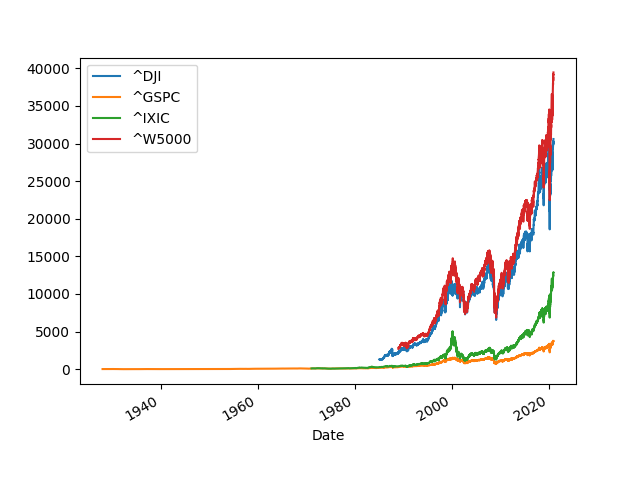

<AxesSubplot:xlabel='Date'>

In [28]:
daily_data_indexes["Close"].plot()

Понатаму, разгледуваме некои дексриптивни статистики за дневниот прираст на индексите. Можеме да забележиме дека просечниот прираст на сите индекси е позитивен, што е и очекувано, земено предвид дека цената на сите индекси расте.

In [29]:
daily_data_indexes["Return 1"].describe()

,^DJI,^GSPC,^IXIC,^W5000
count,9055.000000,23361.000000,12587.000000,8063.000000
mean,0.000415,0.000302,0.000465,0.000396
std,0.011388,0.011994,0.012518,0.011296
min,-0.226102,-0.204669,-0.123213,-0.122472
25%,-0.004350,-0.004528,-0.004415,-0.004193
50%,0.000579,0.000485,0.001085,0.000731
75%,0.005675,0.005420,0.006094,0.005484
max,0.113650,0.166096,0.141732,0.114011


Ги разгледуваме и boxplot-овите на овие индекси и можеме да забележиме одредени outlier-и кај Dow Jones Industrial Average и S&P 500.

<IPython.core.display.Javascript object>


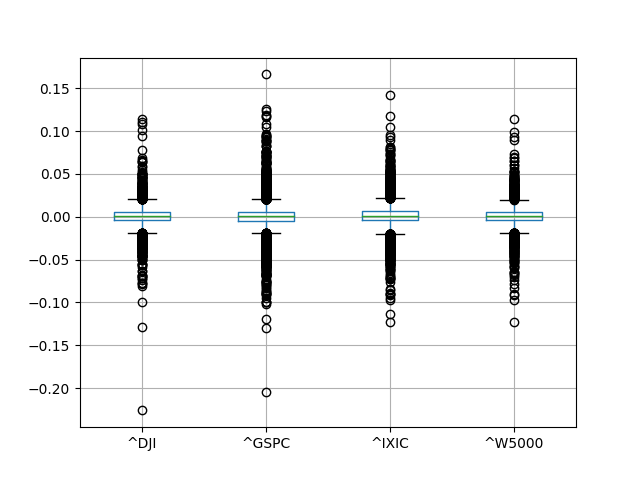

<AxesSubplot:>

In [30]:
daily_data_indexes["Return 1"].boxplot()

Но, за да добиеме подобар осет за како овие податоци се споредуваат едни со други, потребно е да ги доведеме до ист број на записи. Едноставно, тешко е да се споредуваат податоците на S&P 500 во 1930тите со другите индекси кои почнале да постојат многу подоцна. За оваа цел, пред да ги погледнеме дескриптивните статистики и да ги исцртаме boxplot-овите, потребно е да направиме `.dropna`.

Вака изгледа цената на индексите сега.

<IPython.core.display.Javascript object>


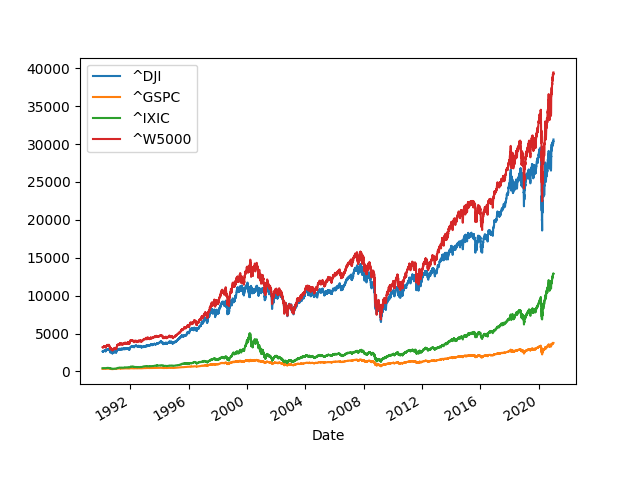

<AxesSubplot:xlabel='Date'>

In [31]:
daily_data_indexes.dropna()["Close"].plot()

Повторно сите индекси имаат позитивен просечен прираст, што е очекувано.

In [32]:
daily_data_indexes.dropna()["Return 1"].describe()

,^DJI,^GSPC,^IXIC,^W5000
count,7779.000000,7779.000000,7779.000000,7779.000000
mean,0.000378,0.000377,0.000544,0.000388
std,0.011143,0.011484,0.014627,0.011418
min,-0.129265,-0.119841,-0.123213,-0.122472
25%,-0.004416,-0.004350,-0.005578,-0.004238
50%,0.000551,0.000582,0.001153,0.000700
75%,0.005590,0.005649,0.007419,0.005567
max,0.113650,0.115800,0.141732,0.114011


Од друга страна, можеме да забележиме дека бројот на outlier-и кај S&P 500 се намалува, што не наведува да помислиме дека претходните outlier-и биле од периодот кога останатите индекси не постоеле (можеби за време на и после Големата Економска Депресија во 1927 и за време на и после Втората Светска Војна).

<IPython.core.display.Javascript object>


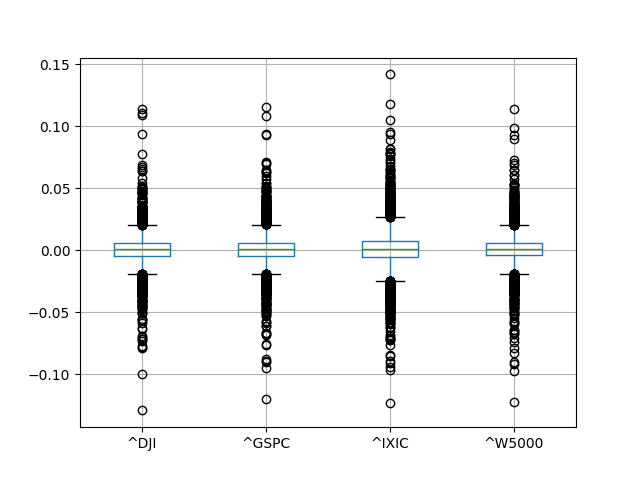

<AxesSubplot:>

In [33]:
daily_data_indexes.dropna()["Return 1"].boxplot()

За да добиеме некој осет за распределбите на прирастите на четирите индекси, потребно е и да ги исцртаме хистограмите. Хистограмите изгледаат делумно симетрично и наликуваат на нормални, но вреди да се забележи дека десната страна опаѓа делумно побрзо од левата страна. Во секој случај, со помош на статистички тестови, ќе ја тестираме хипотезата дека прирастот е нормален.

<IPython.core.display.Javascript object>


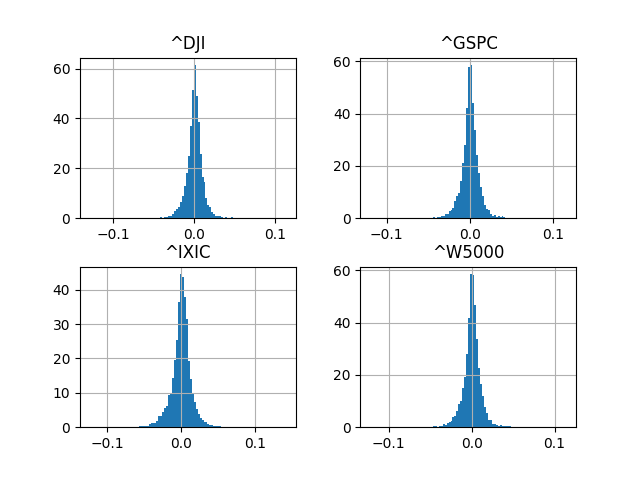

array([[<AxesSubplot:title={'center':'^DJI'}>,
        <AxesSubplot:title={'center':'^GSPC'}>],
       [<AxesSubplot:title={'center':'^IXIC'}>,
        <AxesSubplot:title={'center':'^W5000'}>]], dtype=object)

In [34]:
daily_data_indexes.dropna()["Return 1"].hist(bins=100, density=True)

Ќе разгледаме повеќе дистрибуции кои наликуваат на нормалната и можат да ги опишат прирастите, поделени на 4 фамилии:
- нормална дистрибуција, опишана со параметрите `loc` (очекувана вредност) и `scale` (стандардна девијација); нема директно да тестираме за нормална, ќе го користиме тестот за обопштена нормална дистрибуција
- коши дистрибуција, слична на нормалната по облик, но со потешки опашки, па затоа нема очекувана вредност/стандардна девијација; опишана со параметрите `loc` (медијана) и `scale` (оценето со медијана на абсолутните вредности на примерокот)
- обопштена нормална дистрибуција, опишана со параметрите `beta` (ја контролира формата, 1 соодветствува на лапласова, 2 на нормална), `loc` (очекувана вредност) и `scale` 

Тестирањето на тоа дали податоците доаѓаат од одредена дистрибуција ќе го направиме со помош на тестот на Коломогоров - Смирнов, кој што ги споредува кумулативните распределби (функциите на распределби) на примерокот и на дистрибуцијата која што ја тестираме. Параметрите ќе ги оцениме користејќи го методот `.fit` од пакетот `scipy`.

In [35]:
from scipy import stats


def get_distribution(df):
    cauchy_p_value = stats.kstest(df, "cauchy", stats.cauchy.fit(df))[1]
    gennorm_p_value = stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]
    p_values = list(
        zip([cauchy_p_value, gennorm_p_value], [0, 1]))

    return max(p_values)[1]

Кога ќе ја најдеме најдобрата дистрибуција на секој можен период од година дена за индексот S&P 500, забележуваме дека најчесто дневните прирасти во временски период од 1 година се поблиску до обопштена нормална дистрибуција (89% од времето) отколку до коши дистрибуцијата со тешки опашки.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


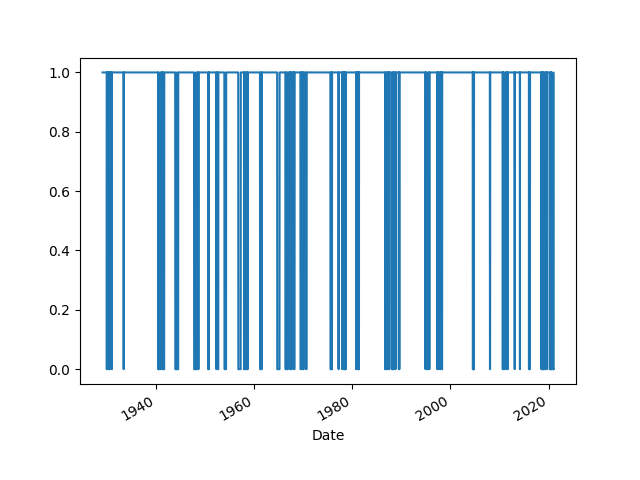

66.09s


In [38]:
from pandarallel import pandarallel
pandarallel.initialize()

start_time = time.time()
x = daily_data_indexes[("Return 20", "^GSPC")].interpolate()
dists = x.rolling(250).parallel_apply(get_distribution)
dists.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

In [39]:
(dists == 1).mean(), (dists == 0).mean()

(0.8885797448848557, 0.0999058299803099)

Од овој график можеме да заклучиме дека обопштената нормална дистрибуција задоволително го моделира дневниот прираст во временски интервал од една година. Исцртувајќи го кумулативниот хистограм на p-вредностите подоле, забележуваме дека p-вредноста е помала од 0.6 20% од времето, помала од 0.4 е 10% од времето итн., што и е очекувано (посебно во периоди на економски кризи, каде што очекувано е дистрибуција со потешки опашки, како кошиевата дистрибуција, да даде посоодветен опис на дневните прирасти). Истовремено, повеќе од пола од времето, p-вредноста е над 0.85, што означува доста висока сигурност дека податоците доаѓаат од таа дистрибуција. Средната p-вредност изнесува 0.76, што е уште еден показател дека оваа дистрибуција добро ги моделира податоците.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


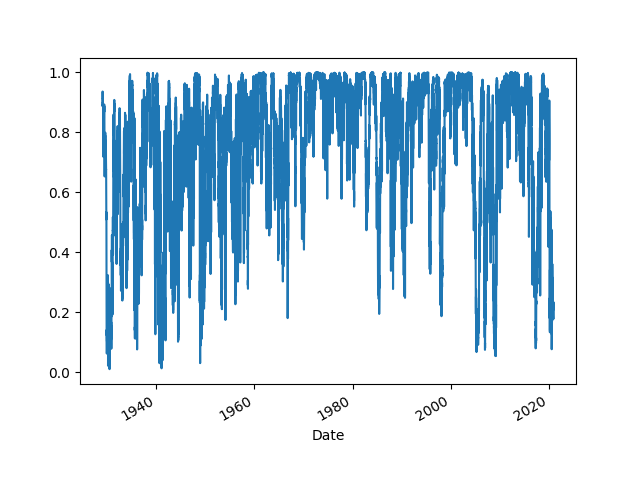

48.82s


In [40]:
def get_gennorm_p_values(df):
    return stats.kstest(df, "gennorm", stats.gennorm.fit(df))[1]

pandarallel.initialize()
start_time = time.time()
x = daily_data_indexes[("Return 1", "^GSPC")].interpolate()
gennorm_p_values = x.rolling(250).parallel_apply(get_gennorm_p_values)
gennorm_p_values.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


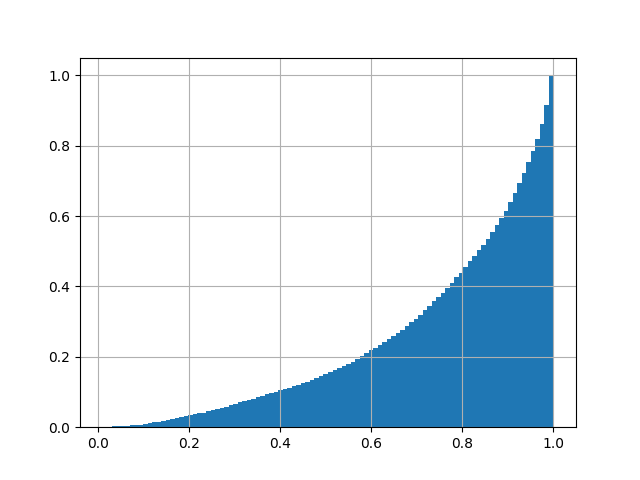

<AxesSubplot:>

In [41]:
gennorm_p_values.hist(cumulative=True, density=1, bins=100)

In [42]:
gennorm_p_values.mean()

0.7638051737199568

Ни останува уште да видиме како бета-та се менува со тек на времето. Но пред да го сториме тоа, да кажеме некој збор за значењето на бетата во обоштената нормална дистрибуција.

Бетата во обопштената нормална дистрибуција ја одредува формата на самата дистрибуција, без притоа да влијае на очекуваната вредност или на дисперзијата на распределбата. Колку што е бетата повисока, толку повеќе распределбата стреми кон униформна, односно, врвот и се израмнува. Кога бетата е 1, обопштената нормална дистрибуција е иста со лапласовата (двојно-експоненцијална) дистрибуција. Кога бетата е 2, обопштената нормална дистрибуција е исто со нормалната дистрибуција.

Неколку бети и соодветните обопштени нормални дистрибуции можат да се видат на оваа слика од Википедија.

![Обопштени нормални дистрибуции](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Generalized_normal_densities.svg/1280px-Generalized_normal_densities.svg.png)

Подоле е претставено како бетите се менуваат со текот на времето. Бетите индицираат дека распределбата најчесто е блиску до лапласова (најмногу се бетите концентрирани помеѓу 0.8 и 1.5). Интересно е да се забележи дека пред кризата од 2008 година, денвниот прираст генерално бил објаснет со обопштени нормални дистрибуции помеѓу лапласовата и нормалната. После кризата се забележуваат пониски бети.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


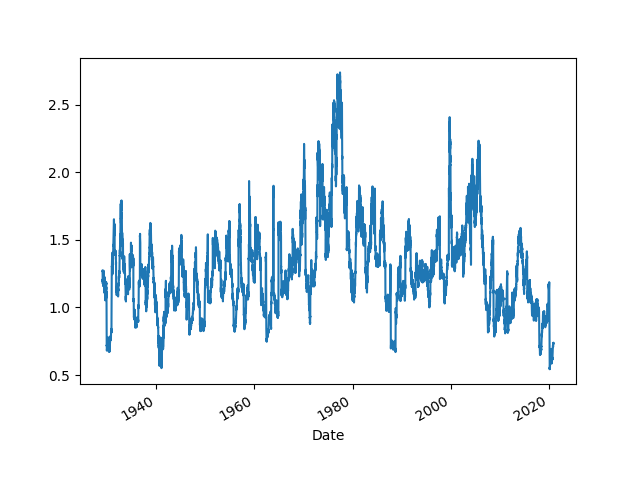

44.49s


In [43]:
def get_gennorm_betas(df):
    return stats.gennorm.fit(df)[0]

pandarallel.initialize()
start_time = time.time()
x = daily_data_indexes[("Return 1", "^GSPC")].interpolate()
betas = x.rolling(250).parallel_apply(get_gennorm_betas)
betas.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


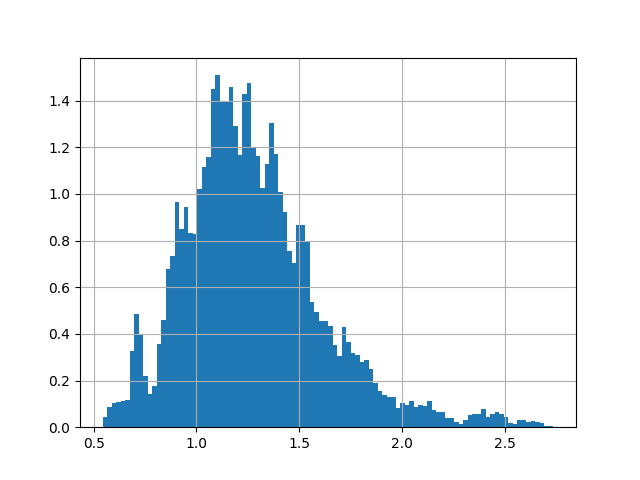

<AxesSubplot:>

In [44]:
betas.hist(density=True, bins=100)

In [45]:
(betas[(betas.index < "2008-01-01") & ((betas.index > "1998-01-01"))].mean(), 
 betas[(betas.index < "2018-01-01") & ((betas.index > "2008-01-01"))].mean())

(1.4962033706361004, 1.101797542808795)

## Распределба на ризикот на индексите

Моделирајќи го дневниот прираст со обопштената нормална дистрибуција, за варијансата добиваме дека изнесува $\frac{\alpha^2\Gamma(\frac{3}{\beta})}{\Gamma(\frac{1}{\beta})}$, каде што $\alpha$ е параметарот `scale` на обопштената нормална дистрибуција. Бидејќи бета-та не е иста секогаш, очигледно е дека варијансата (што е ризикот на квадрат) е хетероскедастична во однос на бетата. За да ја отстраниме хетероскедастичноста што е предизвикана од бетите, ќе мораме ризикот да го сведеме на алфа.

<IPython.core.display.Javascript object>


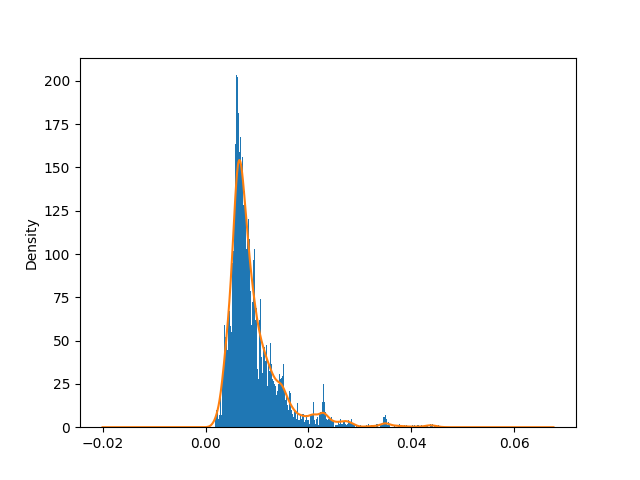

<AxesSubplot:ylabel='Density'>

In [46]:
from scipy.special import gamma

alpha = (((daily_data_indexes[("Risk 1", "^GSPC")] ** 2) * gamma(1 / betas) / gamma(3 / betas)) ** 0.5)
alpha.hist(density=True, bins=1000)
alpha.plot.density()

<IPython.core.display.Javascript object>


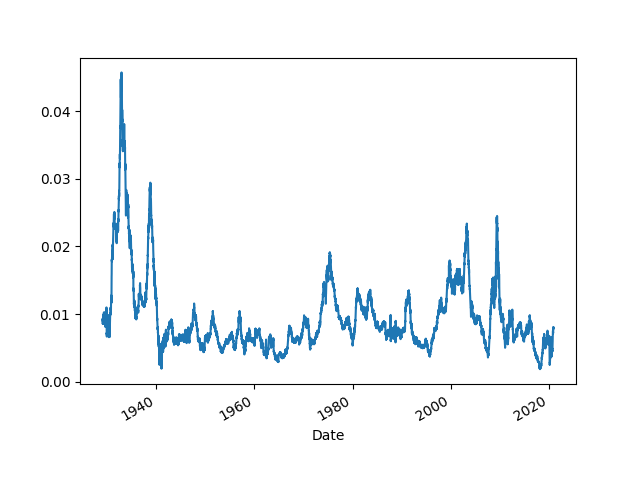

<AxesSubplot:xlabel='Date'>

In [47]:
alpha.plot()

Обидот да најдеме некоја распределба што убаво ќе го опише ризикот е науспешен. Пробуваме 7 различни дистрибуции, но ризикот е посложен од ова. Просекот на најдобрите p-вредности за периодот после 2015 година е 0.25, што е доста ниско.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/jovan/magisterski/exploratory/.venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


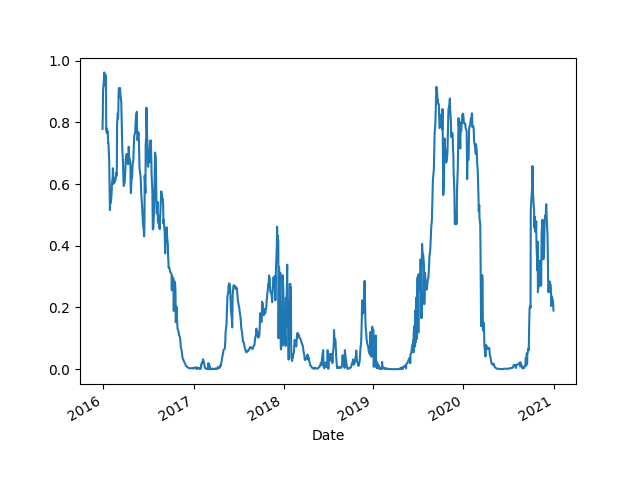

73.34s


In [48]:
def get_distribution(df):
    skewnorm_p_value = stats.kstest(df,
                                    "skewnorm",
                                    args=stats.skewnorm.fit(df))[1]
    exponnorm_p_value = stats.kstest(df,
                                     "exponnorm",
                                     args=stats.exponnorm.fit(df))[1]
    beta_p_value = stats.kstest(df, "beta", args=stats.beta.fit(df))[1]
    log_gamma_p_value = stats.kstest(df,
                                     "loggamma",
                                     args=stats.loggamma.fit(df))[1]
    gamma_p_value = stats.kstest(df, "gamma", args=stats.gamma.fit(df))[1]
    lognorm_p_value = stats.kstest(df, "lognorm",
                                   args=stats.lognorm.fit(df))[1]
    gennorm_p_value = stats.kstest(df, "gennorm",
                                   args=stats.gennorm.fit(df))[1]

    return max([
        exponnorm_p_value, beta_p_value, log_gamma_p_value, gamma_p_value,
        lognorm_p_value, gennorm_p_value, skewnorm_p_value
    ])


pandarallel.initialize()
start_time = time.time()
x = alpha[alpha.index > "2015-01-01"]
p_values = x.rolling(250).parallel_apply(get_distribution)
p_values.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


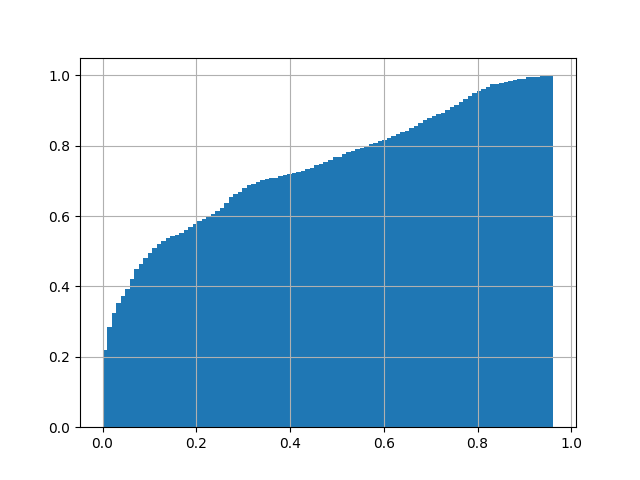

<AxesSubplot:>

In [49]:
p_values.hist(cumulative=True, density=True, bins=100)

In [50]:
p_values.mean()

0.2528120095278868

## Распределба на Sharpe соодносот

Sharpe соодносто би требало да има иста распределба како и дневниот прираст, само со намалена варијанса (бидејќи го скалираме со поделбата со неговата варијанса). Варијансата може потенцијално да биде и 1. Очекувано, откако го правиме тестот, речиси добиваме иста сигурност како и кога ја тестиравме распределбата на дневниот прираст.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


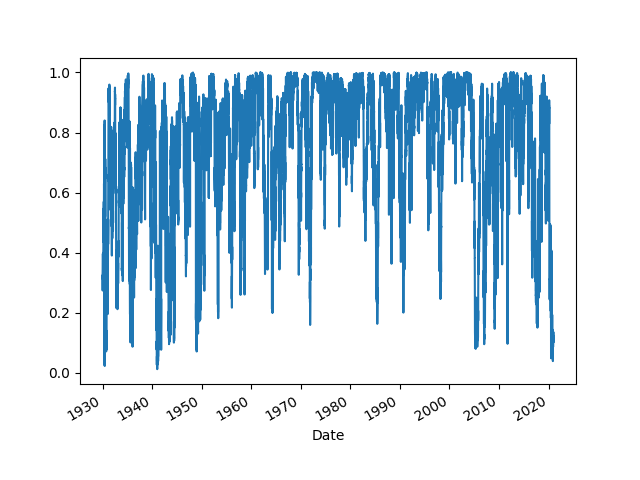

48.50s


In [51]:
pandarallel.initialize()
start_time = time.time()
x = daily_data_indexes[("Sharpe 1", "^GSPC")].interpolate()
gennorm_p_values = x.rolling(250).parallel_apply(get_gennorm_p_values)
gennorm_p_values.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


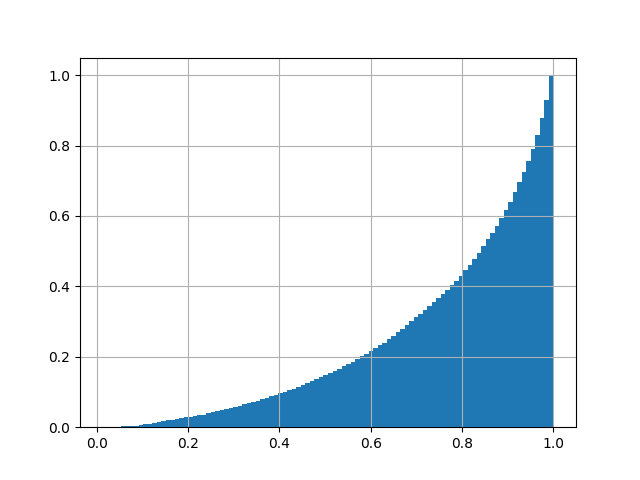

<AxesSubplot:>

In [52]:
gennorm_p_values.hist(cumulative=True, density=1, bins=100)

In [53]:
gennorm_p_values.mean()

0.7669188769835505

Ако ја плотираме варијансата на Sharpe соодност, забележуваме дека нашата претпоставка беше горе-доле вистинита, односно, дека варијансата навистина се движи околу еден. Просечната варијанса е 0.94 и 99.7% од варијансите се наоѓаат помеѓу 0.9 и 1.1.

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<IPython.core.display.Javascript object>


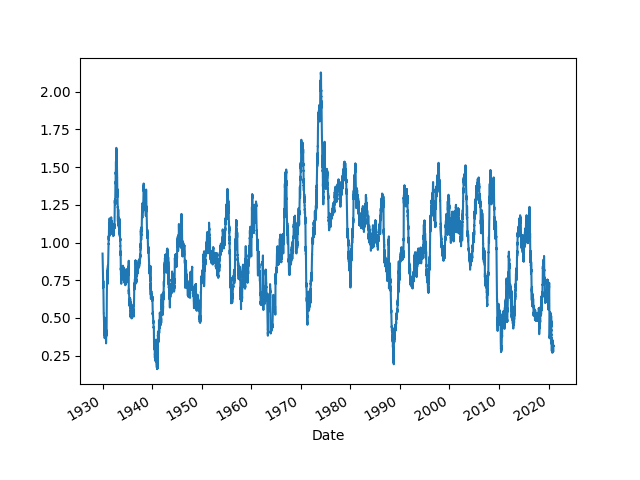

44.92s


In [54]:
def get_gennorm_scales(df):
    return stats.gennorm.fit(df)[2]

pandarallel.initialize()
start_time = time.time()
x = daily_data_indexes[("Sharpe 1", "^GSPC")].interpolate()
scales = x.rolling(250).parallel_apply(get_gennorm_scales)
scales.plot()
end_time = time.time()
print(f"{end_time - start_time:.2f}s")

<IPython.core.display.Javascript object>


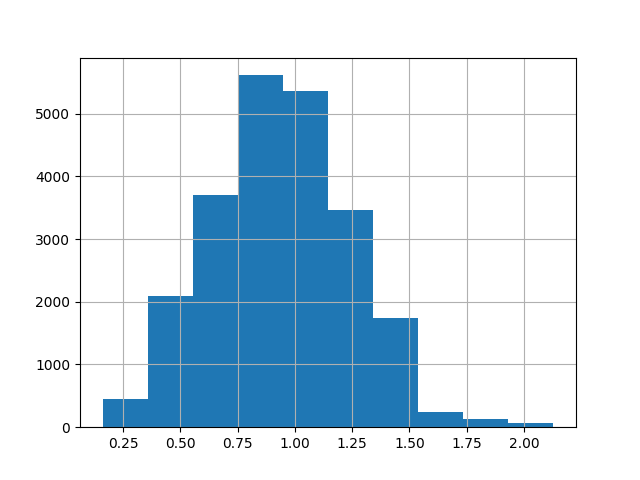

<AxesSubplot:>

In [55]:
scales.hist()

In [56]:
scales.mean(), scales[(scales > 0.9) & (scales < 1.1)].dropna().mean()

(0.9406934336681868, 0.9974769052433484)

## Споредба на средни вредности

Знаеме дека податоците не доаѓаат од нормална распределба, па затоа ќе го кориситме непараметарскиот тест на Крускал - Валис за споредба на сите средни вредности.

### Споредба на среден дневен прираст

Уште кога го правиме првиот тест, забележуваме дека постои разлика помеѓу трите индекси. Наредните два теста ни покажуваат дека разликата не е голема помеѓу индексите S&P 500 и Dow Jones Industrial Average, но Nasdaq Composite е различен од двата.

In [57]:
x = daily_data_indexes.dropna()
print(stats.kruskal(x[("Return 1", "^GSPC")], x[("Return 1", "^DJI")], x[("Return 1", "^IXIC")]))
print(stats.kruskal(x[("Return 1", "^GSPC")], x[("Return 1", "^DJI")]))
print(stats.kruskal(x[("Return 1", "^GSPC")], x[("Return 1", "^IXIC")]))
print(stats.kruskal(x[("Return 1", "^DJI")], x[("Return 1", "^IXIC")]))

KruskalResult(statistic=9.647348920029433, pvalue=0.008037200443164465)
KruskalResult(statistic=0.023936447177950786, pvalue=0.8770467278200442)
KruskalResult(statistic=6.818534298319548, pvalue=0.009021658009768944)
KruskalResult(statistic=7.628247992414424, pvalue=0.005746109379417918)


Од трите индекси, S&P 500 најдобро го отсликува дневниот прираст на берзата на САД.

In [58]:
print(stats.kruskal(x[("Return 1", "^W5000")], x[("Return 1", "^GSPC")]))
print(stats.kruskal(x[("Return 1", "^W5000")], x[("Return 1", "^DJI")]))
print(stats.kruskal(x[("Return 1", "^W5000")], x[("Return 1", "^IXIC")]))

KruskalResult(statistic=0.21310785254123996, pvalue=0.6443423302041371)
KruskalResult(statistic=0.3798060877513629, pvalue=0.5377070331641536)
KruskalResult(statistic=5.275678961243751, pvalue=0.021625352538241223)


### Споредба на среден дневен ризик

Оваа споредба можеме да ја направиме на два начини: преку тестирање на еднаквоста на варијансите на прирастите и преку тестирање на еднаквоста на средините на ризиците. Тестот на Левене покажува дека S&P 500 и Dow Jones Industrial Average имаат до некаде сличен ризик, но Nasdaq Composite е различен од двата.

In [59]:
print(stats.levene(x[("Return 1", "^GSPC")], x[("Return 1", "^DJI")], x[("Return 1", "^IXIC")]))
print(stats.levene(x[("Return 1", "^GSPC")], x[("Return 1", "^DJI")]))
print(stats.levene(x[("Return 1", "^GSPC")], x[("Return 1", "^IXIC")]))
print(stats.levene(x[("Return 1", "^DJI")], x[("Return 1", "^IXIC")]))

LeveneResult(statistic=164.6688099561375, pvalue=9.665569626958147e-72)
LeveneResult(statistic=2.0748849540649337, pvalue=0.14976135576555608)
LeveneResult(statistic=204.9843669039392, pvalue=3.355456118643162e-46)
LeveneResult(statistic=248.45999172918704, pvalue=1.5133629609184854e-55)


Сличен резултат се добива и со тестот на Крускал - Валис кој е директно направен на ризикот. Евидентно е дека иако S&P 500 и Dow Jones Industrial Average имаат до некаде сличен ризик, таа сличност не е статистички важна.

In [60]:
print(stats.kruskal(x[("Risk 1", "^GSPC")], x[("Risk 1", "^DJI")], x[("Risk 1", "^IXIC")]))
print(stats.kruskal(x[("Risk 1", "^GSPC")], x[("Risk 1", "^DJI")]))
print(stats.kruskal(x[("Risk 1", "^GSPC")], x[("Risk 1", "^IXIC")]))
print(stats.kruskal(x[("Risk 1", "^DJI")], x[("Risk 1", "^IXIC")]))

KruskalResult(statistic=1321.1020749171294, pvalue=1.3376097208803666e-287)
KruskalResult(statistic=8.121675890666666, pvalue=0.004373910707008348)
KruskalResult(statistic=908.423904317744, pvalue=1.4473533857621399e-199)
KruskalResult(statistic=1065.1068382968733, pvalue=1.2671424066744454e-233)


И тестот на Левене, и Крускал - Валис тестот ни кажуваат дека Nasdaq Compositе има различен ризик од остатокот на берзата на САД. На краткорочни пресметки, Dow Jones Industrial Average има доста сличен ризик како и остатокот на берзата на САД (ризикот беше пресметан за интервал од 250 дена, па Крускал - Валис тестот за директни споредби на ризиците е всушност тест за еднаквост на ризиците во зададена една година!), додека S&P 500 во целост има доста сличен ризик со остатокот на берзата на САД, но на краткорочни пресметки се разликува.

In [61]:
print(stats.levene(x[("Return 1", "^W5000")], x[("Return 1", "^GSPC")]))
print(stats.levene(x[("Return 1", "^W5000")], x[("Return 1", "^DJI")]))
print(stats.levene(x[("Return 1", "^W5000")], x[("Return 1", "^IXIC")]))

print(stats.kruskal(x[("Risk 1", "^W5000")], x[("Risk 1", "^GSPC")]))
print(stats.kruskal(x[("Risk 1", "^W5000")], x[("Risk 1", "^DJI")]))
print(stats.kruskal(x[("Risk 1", "^W5000")], x[("Risk 1", "^IXIC")]))

LeveneResult(statistic=0.2519807612373307, pvalue=0.6156909077049129)
LeveneResult(statistic=0.8691432063332062, pvalue=0.35120708334474726)
LeveneResult(statistic=218.2933905480544, pvalue=4.583255309386232e-49)
KruskalResult(statistic=4.5357070243990165, pvalue=0.03319474172480761)
KruskalResult(statistic=0.4412584826568491, pvalue=0.506515664025778)
KruskalResult(statistic=1069.980526936888, pvalue=1.10542143639521e-234)


### Споредба на Sharpe соодносот

Sharpe соодносот прави одредени индекси да се поинтересни за инвеститорите од други, бидејќи мери колкав прираст се очекува за едница ризик. Вака изгледаат Sharpe соодносите за трите индекси во овој проект. Од самите boxplot-ови не можеме да заклучиме дали има разлика во Sharpe соодносите меѓу индексите, па затоа тестираме со помош на тестот Крускал - Валис. Забележуваме дека постои статистички значајна сличност помеѓу средните Sharpe соодноси на индексите S&P 500 и Dow Jones Industrial Average.

<IPython.core.display.Javascript object>


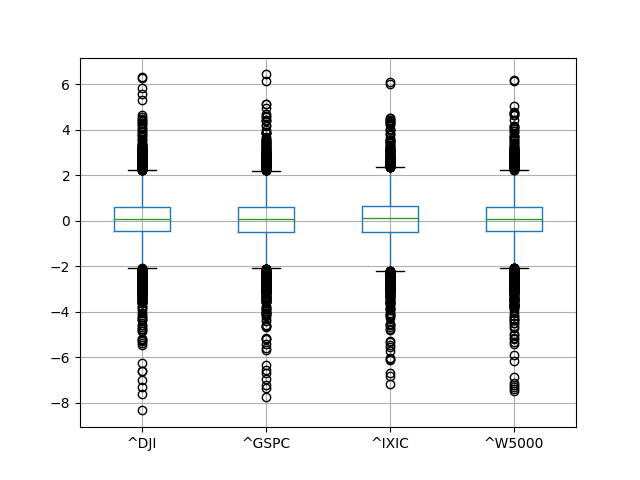

<AxesSubplot:>

In [62]:
x["Sharpe 1"].boxplot()

In [63]:
print(stats.kruskal(x[("Sharpe 1", "^GSPC")], x[("Sharpe 1", "^DJI")], x[("Sharpe 1", "^IXIC")]))
print(stats.kruskal(x[("Sharpe 1", "^GSPC")], x[("Sharpe 1", "^DJI")]))
print(stats.kruskal(x[("Sharpe 1", "^GSPC")], x[("Sharpe 1", "^IXIC")]))
print(stats.kruskal(x[("Sharpe 1", "^DJI")], x[("Sharpe 1", "^IXIC")]))

KruskalResult(statistic=2.506388082567809, pvalue=0.28559114860285395)
KruskalResult(statistic=0.009141591663370904, pvalue=0.9238289954195832)
KruskalResult(statistic=2.0351654491899844, pvalue=0.15369745924090844)
KruskalResult(statistic=1.7153453233591984, pvalue=0.19029330829035376)


Од друга страна забележуваме дека нема статистички значајна разлика помеѓу Sharpe соодносот на овие три индекси и остатокот од берзата на САД, но дека Dow Jones Industrial Average е најблиску.

In [64]:
print(stats.kruskal(x[("Sharpe 1", "^W5000")], x[("Sharpe 1", "^GSPC")]))
print(stats.kruskal(x[("Sharpe 1", "^W5000")], x[("Sharpe 1", "^DJI")]))
print(stats.kruskal(x[("Sharpe 1", "^W5000")], x[("Sharpe 1", "^IXIC")]))

KruskalResult(statistic=0.3536844673402737, pvalue=0.55203481627108)
KruskalResult(statistic=0.24232700668758633, pvalue=0.6225304566787059)
KruskalResult(statistic=0.7451581406909904, pvalue=0.38801353524569726)


### Споредба на средни дневни прирасти по денови

Плотирајќи ги средните дневни прирасти, веднаш забележуваме разлика. Индексот Dow Jones Industrial Average е очигледно најпрофитабилен во понеделник и вторник, додека се забележува тренд на пад на профитабилноста после среда.

Nasdaq Composite, од друга страна, е најпрофитабилен во среда, а понеделник бележи и негативен среден дневен прираст.

<IPython.core.display.Javascript object>


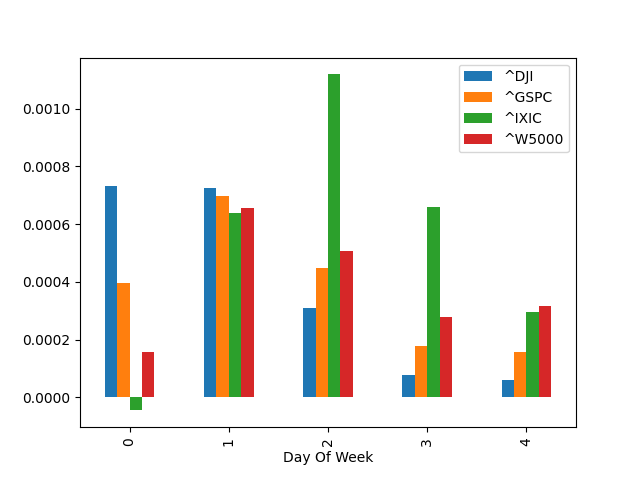

<AxesSubplot:xlabel='Day Of Week'>

In [65]:
daily_data_indexes.dropna().groupby("Day Of Week").agg("mean")["Return 1"].plot.bar()

Ако ги погледнеме самите акции, забележуваме дека во просек, дневните прирасти се најниски во понеделник. Ова најдобро го покажуваат индексите S&P 500 и Nasdaq Composite. S&P 500 дополнително го запазува моентот дека во вторник има највисоки прирасти. Ова е очекувано, бидејќи овој индекс е составен од највисок број на акции (после The Wilshire 5000, кој ги содржи речиси сите акции и не е толку корисен).

<IPython.core.display.Javascript object>


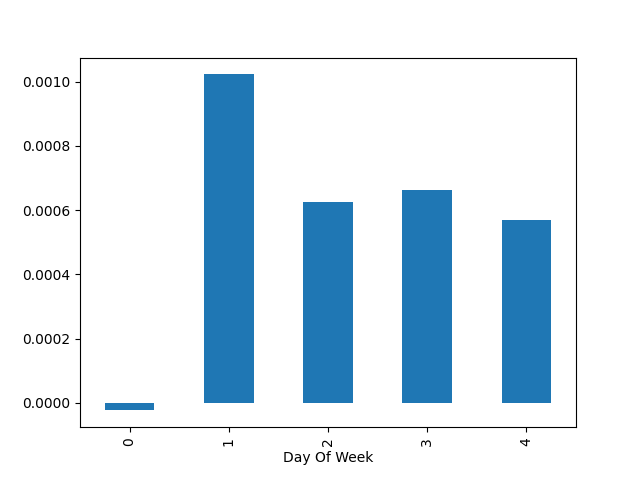

<AxesSubplot:xlabel='Day Of Week'>

In [66]:
twenty_year_daily_tickers.groupby("Day Of Week").agg("mean")["Return 1"].mean(axis=1).plot.bar()

<IPython.core.display.Javascript object>


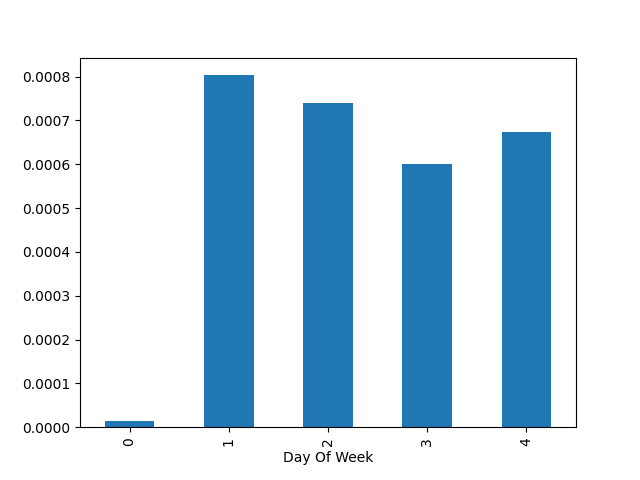

<AxesSubplot:xlabel='Day Of Week'>

In [67]:
fourty_year_daily_tickers.groupby("Day Of Week").agg("mean")["Return 1"].mean(axis=1).plot.bar()

### Споредба на средни дневни прирасти по месеци

Интересно е да се забележи дека јуни, август и септември се месеци кога најмногу паѓаат дневните прирасти.

<IPython.core.display.Javascript object>


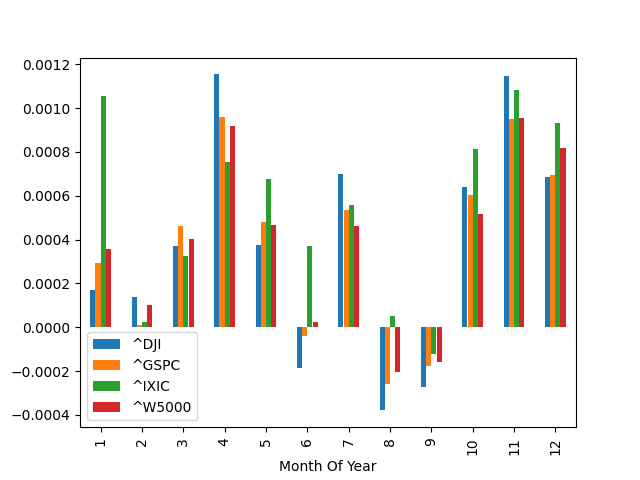

<AxesSubplot:xlabel='Month Of Year'>

In [68]:
daily_data_indexes.dropna().groupby("Month Of Year").agg("mean")["Return 1"].plot.bar()

### Споредба на средни дневни прирасти по квартали

Од овие плотови можеме да заклучиме дека најниски се дневните прирасти во третиот квартал, а највисоки во четвртиот квартал.

<IPython.core.display.Javascript object>


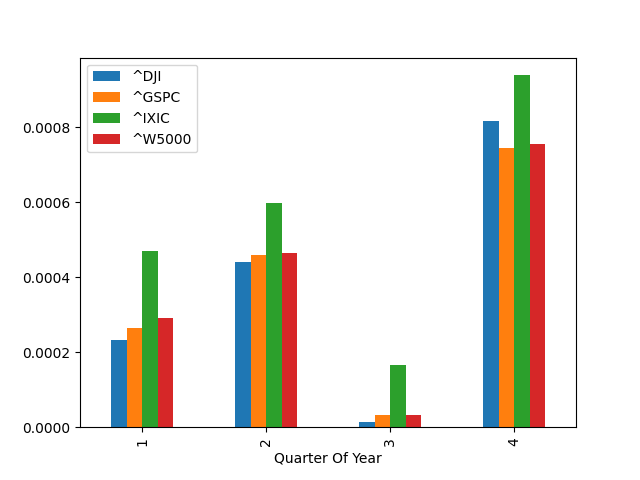

<AxesSubplot:xlabel='Quarter Of Year'>

In [69]:
daily_data_indexes.dropna().groupby("Quarter Of Year").agg("mean")["Return 1"].plot.bar()

<IPython.core.display.Javascript object>


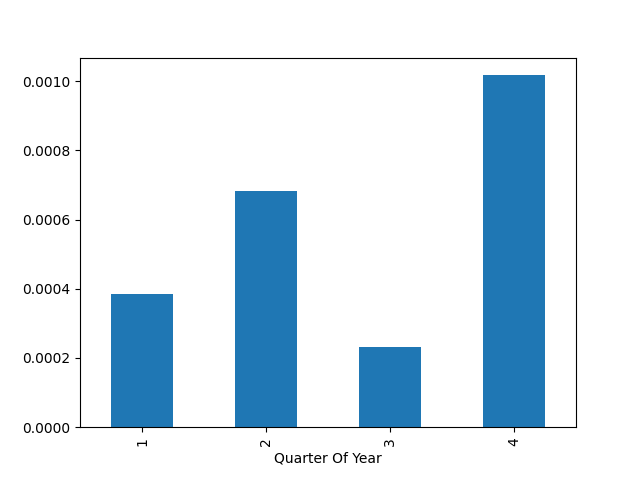

<AxesSubplot:xlabel='Quarter Of Year'>

In [70]:
twenty_year_daily_tickers.groupby("Quarter Of Year").agg("mean")["Return 1"].mean(axis=1).plot.bar()

<IPython.core.display.Javascript object>


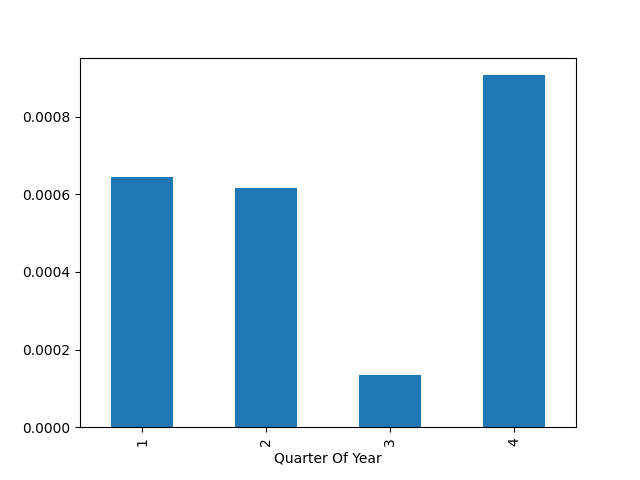

<AxesSubplot:xlabel='Quarter Of Year'>

In [71]:
fourty_year_daily_tickers.groupby("Quarter Of Year").agg("mean")["Return 1"].mean(axis=1).plot.bar()

### Споредба на средни дневни прирасти по години

<IPython.core.display.Javascript object>


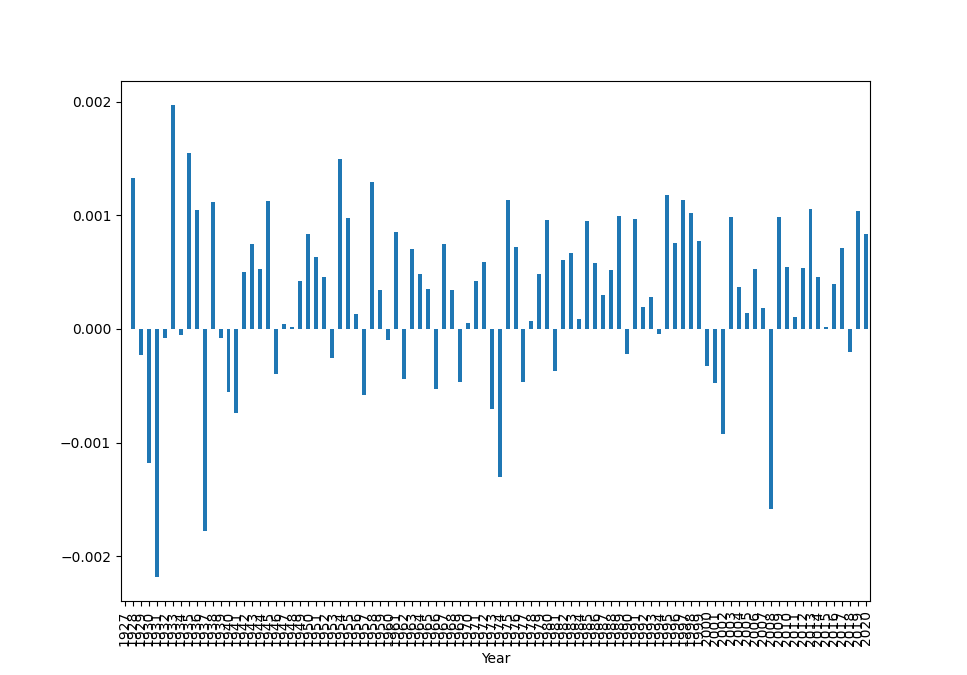

<AxesSubplot:xlabel='Year'>

In [72]:
daily_data_indexes.groupby("Year").agg("mean")[("Return 1", "^GSPC")].plot.bar()

### Споредба на средни дневни прирасти по децении

Од овој график ги исфрламе податоците од 2020-та, бидејќи таа деценија само што започнува и податоците од една година не се релевантни.

<IPython.core.display.Javascript object>


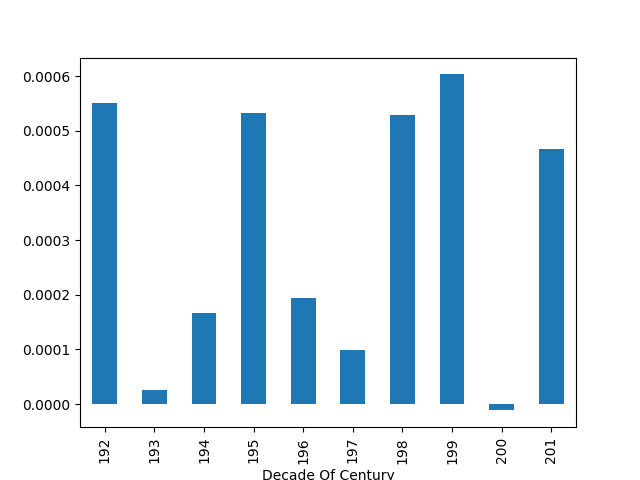

<AxesSubplot:xlabel='Decade Of Century'>

In [73]:
daily_data_indexes[daily_data_indexes.index < "2020-01-01"].groupby(
    "Decade Of Century").agg("mean")[("Return 1", "^GSPC")].plot.bar()

### Споредба на просечен дневен прираст на акции со висок Sharpe сооднос и акции со низок Sharpe сооднос

Sharpe соодносот право пропорционално зависи и од прирастот, и од реципрочната вредност на ризикот. Сега ќе испитаме дали повисок Sharpe сооднос, освен што означува повисок прираст по единица ризик, означува и повисок прираст во општ случај. Можеме да забележиме дека има драстична разлика помеѓу двете.

In [74]:
(twenty_year_daily_tickers["Return 1"] *
 (twenty_year_daily_tickers["Sharpe 1"] > 0)).mean().mean(), (
     twenty_year_daily_tickers["Return 1"] *
     (twenty_year_daily_tickers["Sharpe 1"] < 0)).mean().mean()

(0.006939000123468467, -0.006395697252714794)

In [75]:
(fourty_year_daily_tickers["Return 1"] *
 (fourty_year_daily_tickers["Sharpe 1"] > 0)).mean().mean(), (
     fourty_year_daily_tickers["Return 1"] *
     (fourty_year_daily_tickers["Sharpe 1"] < 0)).mean().mean()

(0.006773172901975576, -0.006202945757115318)

# Статистичка анализа на 5 минутниот прираст

Поради ограничувањата на yfinance, немаме премногу податоци за да правиме статистичка анализа на 5 минутниот прираст како што правевме на дневниот. Затоа, во овој дел од проектот, единствено ќе ги плотираме просечните 5 минутни прирасти за секој час. Забележуваме дека значително повисоки прирасти има при отворањето на берзата сабајле. Веројатно ова се должи на трансакциите кои се поставуваат низ текот на вечерта, како и на вишокот на време што инвеститорите го имаат за да донесат одлука.

<IPython.core.display.Javascript object>


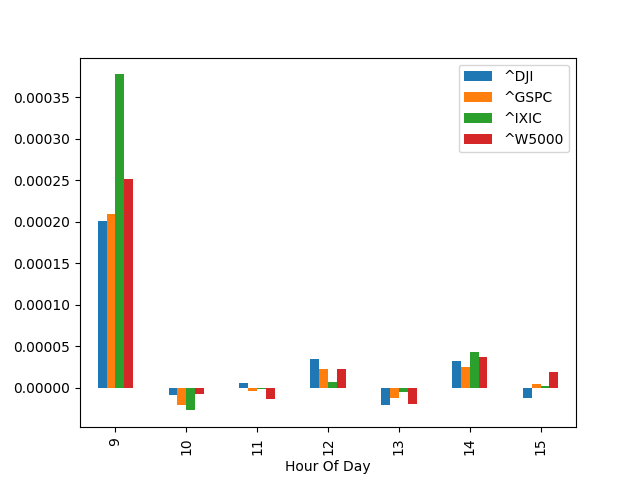

<AxesSubplot:xlabel='Hour Of Day'>

In [76]:
intraday_data_indexes.groupby("Hour Of Day").agg("mean")["Return 1"].plot.bar()

<IPython.core.display.Javascript object>


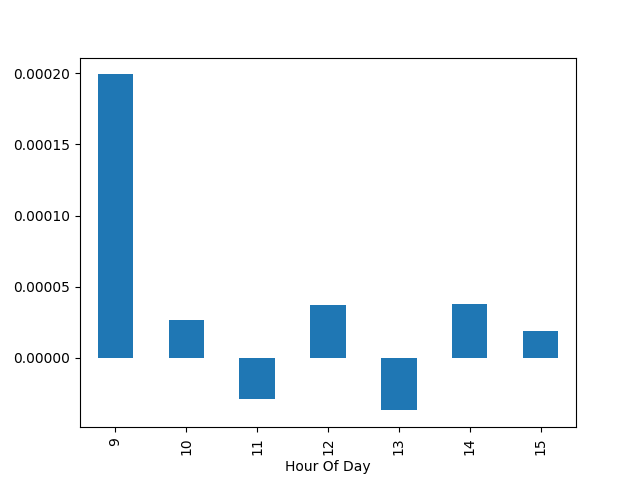

<AxesSubplot:xlabel='Hour Of Day'>

In [77]:
intraday_data_tickers.groupby("Hour Of Day").agg("mean")["Return 1"].mean(axis=1).plot.bar()